## This notebook is meant to merge the information between the PLOS text/references to the Web of Science(WoS) database.

## This notebook collects the data from WoS, generating the dictionary wos_dois

## Then, by taking from the full text of the PLOS papers (the regular PLOS Search notebook), we get the dictionary plos_dict

## ref_dict, which contains the data on the in-text citations, has been assembled in the PLOS Search XML notebook, so this is just loaded in

## The citation count information from plos_dict is inserted into the ref_dict dictionary. All analyses can now be done with just ref_dict.

In [1]:
# This code is the MongoConnection class from the Amaral lab LabTools folder.

from __future__ import print_function, unicode_literals
import sys
from pymongo import MongoClient


class MongoConnection(object):
    def __init__(self, cxnSettings, **kwargs):
        self.settings = cxnSettings
        self.mongoURI = self._constructURI()
        self.connect(**kwargs)
        self.ensure_index()

    def _constructURI(self):
        '''
        Construct the mongo URI
        '''
        mongoURI = 'mongodb://'
        #User/password handling
        if 'user'in self.settings and 'password' in self.settings:
            mongoURI += self.settings['user'] + ':' + self.settings['password']
            mongoURI += '@'
        elif 'user' in self.settings:
            print('Missing password for given user, proceeding without either')
        elif 'password' in self.settings:
            print('Missing user for given passord, proceeding without either')
        #Host and port
        try:
            mongoURI += self.settings['host'] + ':'
        except KeyError:
            print('Missing the hostname. Cannot connect without host')
            sys.exit()
        try:
            mongoURI += str(self.settings['port'])
        except KeyError:
            print('Missing the port. Substituting default port of 27017')
            mongoURI += str('27017')
        return mongoURI

    def connect(self, **kwargs):
        '''
        Establish the connection, database, and collection
        '''
        self.connection = MongoClient(self.mongoURI, **kwargs)
        #########
        try:
            self.db = self.connection[self.settings['db']]
        except KeyError:
            print("Must specify a database as a 'db' key in the settings file")
            sys.exit()
        #########
        try:
            self.collection = self.db[self.settings['collection']]
        except KeyError:
            print('Should have a collection.', end='')
            print('Starting a collection in database', end='')
            print(' for current connection as test.')
            self.collection = self.db['test']

    def tearDown(self):
        '''
        Closes the connection
        '''
        self.connection.close()

    def ensure_index(self):
        '''
        Ensures the connection has all given indexes.
        indexes: list of (`key`, `direction`) pairs.
            See docs.mongodb.org/manual/core/indexes/ for possible `direction`
            values.
        '''
        if 'indexes' in self.settings:
            for index in self.settings['indexes']:
                self.collection.ensure_index(index[0], **index[1])

In [2]:
import sys

#Due to leftoevererrors in Nathan's python installation, some cleaning up occurs here
#sys.path.append("./code/")
#sys.path.remove('/usr/local/lib/python2.7/site-packages') 


import matplotlib.pyplot as plt
%matplotlib inline
import copy
import datetime
import json
import networkx as nx
from networkx import *
import nltk
import pickle
import gzip
import os,glob
import regex as re
import time
import Levenshtein as lev
import numpy as np
from scipy import stats
#sys.path

ImportError: No module named 'regex'

# Prepare connection settings for the papers in our WoS database

In [4]:
merged_papers_settings = {
    "host": "chicago.chem-eng.northwestern.edu",
    "port": "27017",
    "db": "web_of_science_aux",
    "collection": "merged_papers",
    "user": "mongoreader",
    "password": "emptycoffeecup"
}

# Connection settings for the issues collection

In [5]:
issues_settings = {
    "host": "chicago.chem-eng.northwestern.edu",
    "port": "27017",
    "db": "web_of_science_aux",
    "collection": "issues",
    "user": "mongoreader",
    "password": "emptycoffeecup"
}

In [6]:
journal_settings = {
    "host": "chicago.chem-eng.northwestern.edu",
    "port": "27017",
    "db": "web_of_science_aux",
    "collection": "journals",
    "user": "mongoreader",
    "password": "emptycoffeecup"
}

# Initialize Connections

In [7]:
papers_con = MongoConnection(merged_papers_settings)
issue_con = MongoConnection(issues_settings)
journal_con = MongoConnection(journal_settings)

In [119]:
#Ex: Find document via an indexed field. For papers_con, this is usually 'UT'
doc = papers_con.collection.find_one({"UT":"A1996UD26900001"})
doc

{'AB': 'To clarify mechanisms of hypothermia in lipopolysaccharide (LPS) shock, four experiments were conducted in 72 chronically instrumented Wistar rats. They were intended to accomplish the following: experiment 1, determine the dose of intravenous Escherichia coli LPS that induces a body temperature (T-b) fall at a minimal mortality [the dose chosen (0.5 mg/kg) was then used in experiments 2-4]; experiment 2, identify the time course of the arterial blood pressure (BP) fall (shock) during the response to LPS; experiment 3, measure threshold T-b values for skin vasodilation and activation of metabolic heat production (ill) during the LPS shock; and experiment 4, ascertain behavioral thermoregulation in LPS shock. For experiments 1-3, rats were kept in restrainers; ambient temperature (T-a) was 26 degrees C. In experiment 4, rats freely moved in a thermogradient (18-33 degrees C). Variables monitored were colonic (T-c) and tail skin (T-sk) temperatures (experiment 1); BP experiment 2

In [117]:
ref_paper = papers_con.collection.find_one({"UT": '000278034600008'})
ref_paper

{'AB': ['Background: Mycobacterium tuberculosis, the causative agent of tuberculosis, still represents a major public health threat in many countries. Bioluminescence, the production of light by luciferase-catalyzed reactions, is a versatile reporter technology with multiple applications both in vitro and in vivo. In vivo bioluminescence imaging (BLI) represents one of its most outstanding uses by allowing the non-invasive localization of luciferase-expressing cells within a live animal. Despite the extensive use of luminescent reporters in mycobacteria, the resultant luminescent strains have not been fully applied to BLI.',
  'Methodology/Principal Findings: One of the main obstacles to the use of bioluminescence for in vivo imaging is the achievement of reporter protein expression levels high enough to obtain a signal that can be detected externally. Therefore, as a first step in the application of this technology to the study of mycobacterial infection in vivo, we have optimised the

In [120]:
# Our WoS database has the 'citations' field as an added entry. This entry is not always accurate and
# lags behind the actual citation listing in WoS as well as the actual citation listing of the article.
# If citations exist, will be a list of UTs. This means that non-WoS indexed articles/books do not appear
# in this field.

doc['citations']

[]

In [327]:
#Ex: Find journal
journ = issue_con.collection.find_one({'UI':'0000762416'})

In [328]:
#Ex: Get ISSN for journal
j_chemo = journal_con.collection.find_one({"SO": "JOURNAL OF CHEMOTHERAPY"}, {"_id": 1})
j_chemo_issn = j_chemo["_id"]
j_chemo_issn

'1120-009X'

In [329]:
#Find all papers in journal from given journal issue/year
cursor = papers_con.collection.find(
    {"issue.PY": 2000, "issue.SN": j_chemo_issn}
)
cursor.count()     # Calling .count() on a cursor does not exhaust it. Meaning you can use it later

86

In order to find all PLOS papers we have in the WoS database, we search by ISSN.

In [129]:
list_of_issns = ['1932-6203', '1545-7885', '1553-7358', '1553-7404', '1549-1676', '1935-2735', '1553-7374', '2157-3999']

journal_abbrev = {'1932-6203': 'pone', '1545-7885': 'pbio', '1553-7358': 'pcbi', '1553-7404': 'pgen', 
                '1549-1676': 'pmed', '1935-2735': 'pntd', '1553-7374': 'ppat', '2157-3999': 'pctr'}

In [149]:
# This code is for generating the dictionary between PLOS articles and Accession Numbers ('UT') from the Web of Science database

wos_dois = {}
failed_ans = []
maybe_faulty_entries = []
count = 0
tot_count =0
for issn in list_of_issns[1:]:
    print('Looking for ' + issn)
    cursor = papers_con.collection.find({"issue.SN": issn})
    print(cursor.count())
    tot_count+=cursor.count()
    k = 0
    for i in cursor:
        count+=1
        k+=1
        try:
            if type(i['AR']) == list:
                doi = i['AR'][1][4:]
                
                # Database error, mostly for PLOSONE, but there's a single duplicate for pbio , pmed, and ppat
                # (So 6 inaccessible papers, since the first one would also be inaccessible)
                if doi == ('10.1371/journal.' + journal_abbrev[issn]):
                    if i['AR'][0]: #Manually inserting from 'ARTN eXXXX' format (typical way that WoS shows the doi)
                        predoi = i['AR'][0][6:]
                           
                        if len(predoi) < 7:
                            maybe_faulty_entries.append(predoi) #Keeping track of entries that may be incorrect due to this appending process
                           
                        while len(predoi) < 7:
                            predoi = '0' + predoi
                           
                        doi = '10.1371/journal.' + journal_abbrev[issn] + '.' + predoi
                try:        
                    doi_parts = doi.split('.')
                    doi_name = doi_parts[2] + '_' + doi_parts[3]
                except:
                    print(doi)
                if doi_name not in wos_dois:
                    wos_dois[doi_name] = {}
                    wos_dois[doi_name]['UT'] = i['UT']
                    
                    #if i['AR'][1][4:] == '10.1371/journal.pone.0003038':
                    #    print('!!!!!!!')
                    #    print(i)
                    #    print('!!!!!!!end')
                else:
                    # There's a bit of bug here where the database has multiple entries with the same DOI, but different ANs. 
                    # Probably due to correction history. Citations are out of order also. Probably not worth
                    # fixing quite yet. Total of 151 duplicates and 47 without keys out of 163162 papers. Also several bad keys
                
                    print('Duplicated ' + doi_name)
                    
                    #print(i)
                    #print(i['AR'][1][4:])
                    
                    
            elif type(i['AR']) == str:
                if 'ARTN' in i['AR']:
                    predoi = i['AR'][6:]
                    if len(predoi) < 7:
                        maybe_faulty_entries.append(predoi) #Keeping track of entries that may be incorrect due to this appending process
                           
                    while len(predoi) < 7:
                        predoi = '0' + predoi
                           
                    doi = '10.1371/journal.' + journal_abbrev[issn] + '.' + predoi
                else:
                    doi = i['AR'][4:]
                
                if doi == ('10.1371/journal.' + journal_abbrev[issn]):
                    print('!!!!!Problem!!!! ' + str(i))
                try:
                    doi_parts = doi.split('.')
                    doi_name = doi_parts[2] + '_' + doi_parts[3]
                except:
                    print(i['AR'])
                if doi_name not in wos_dois:
                    wos_dois[doi_name] = {}
                    wos_dois[doi_name]['UT'] = i['UT']
                else:
                    print('Duplicated ' + doi_name)
                    #print(i['AR'])
            else:
                print(i['AR'])
        except KeyError:
            failed_ans.append(i['UT'])
            #print('Lost one')
        if k%10000 == 0:
            print(k)
print(count)
print(len(failed_ans))

Looking for 1545-7885
1355
Looking for 1553-7358
1434
Duplicated pcbi_1000029
Looking for 1553-7404
2472
Duplicated pgen_1000131
Duplicated pgen_1000118
Duplicated pgen_0020111
10.1371/journal.pgen1003828
Duplicated pgen_1003827
Looking for 1549-1676
1031
10.1371/journal.0040074
Duplicated pmed_0040211
Duplicated pmed_0040211
Duplicated pmed_1001927
Looking for 1935-2735
3829
Duplicated pntd_0002520
Duplicated pntd_0002233
Duplicated pntd_0002812
Duplicated pntd_0002802
Duplicated pntd_0002813
Looking for 1553-7374
1717
Looking for 2157-3999
0
11838
2


In [150]:
tot_count+ 156484

168322

In [189]:
import json
with open('../plos_dict_temp.json', 'w') as fp:
    json.dump(plos_dict, fp)

In [295]:
#plos_dict['pone_0000032']
doc = papers_con.collection.find_one({"UT":'000168710000060'})
doc

{'AB': 'Throughout the entire process of cancer aetiology, progression and metastasis, the microenvironment of the local host tissue can be an active participant. Invasion occurs within a tumour-host microecology, where stroma and tumour cells exchange enzymes and cytokines that modify the local extracellular matrix, stimulate migration, and promote proliferation and survival. A new class of cancer therapies that targets this pathological communication interface between tumour cells and host cells is currently under development.',
 'AU': [{'AU': 'Liotta, LA'}, {'AU': 'Kohn, EC'}],
 'AV': 'Y',
 'BP': '375',
 'C1': {'NC': 'NCI',
  'ND': ['Pathol Lab', 'Ctr Canc Res'],
  'NF': 'NCI, Pathol Lab, Ctr Canc Res, Bethesda, MD 20892 USA',
  'NP': 'MD',
  'NU': 'USA',
  'NY': 'Bethesda',
  'NZ': '20892       AP'},
 'CR': [{'/A': 'ABOSEIF, S',
   '/P': '113',
   '/V': '65',
   '/W': 'DIFFERENTIATION',
   '/Y': '1999',
   'R9': '0070873806'},
  {'/A': 'AIROLA, K',
   '/P': '85',
   '/V': '116',
  

In [80]:
plos_dict_trial = pickle.load(open('../plos_dict_080516.txt', 'rb'))
len(plos_dict_trial)

34014

34014

In [16]:
#wos_dois = pickle.load(open('../wos_dois_dict.txt', 'rb'))
#len(wos_dois)

162971

162971

In [187]:
#test_plos_dict = pickle.load(open('../plos_dict_temp.txt', 'rb'))
#test_plos_dict

{'pone_0001396': {'UT': '000260468900024',
  'references': {0: 'A1994QH20800006',
   1: '000184207300031',
   2: 'A1994NZ24200004',
   3: '000233657600014',
   4: '000077246600048',
   5: '000231610400002',
   6: '000251565300001',
   7: '000181367900027',
   8: '000181281600005',
   9: '000236225300035',
   10: '000237002900018',
   11: '000166434300052',
   12: '000185502300045',
   14: '000235744900001',
   15: '000237954800002',
   16: '000226846100007',
   17: '000186273300015',
   18: '000228986500042',
   19: '000236584400032',
   20: '000244063900026',
   21: '000249124800011',
   22: '000220975100051',
   23: '000224156500016',
   24: '000233593100051',
   25: '000234095500003',
   26: '000075526200004',
   27: '000230195900017',
   28: '000233264300015',
   29: '000175313300001',
   30: '000230449800048',
   31: '000234528000013',
   32: '000226365400006',
   34: '000225676700023',
   35: '000227039200045',
   36: '000185336200004',
   37: '000174227800004',
   38: '000073052

In [160]:
for key in wos_dois.keys():
    if type(paper['CR']) == list:
        print(paper['CR'])
        break

[{'/W': 'DNA RES', 'R9': '0118865894', 'RS': 'DOI 10.1093/dnares/dsm033', '/V': '15', '/A': 'ABE, H', '/Y': '2008', '/P': '25'}, {'/W': 'PLOS PATHOG', 'R9': '0129067170', 'RS': 'UNSP E1000408', '/V': '5', '/A': 'ASADULGHANI, M', '/Y': '2009'}, {'/W': 'MOL MICROBIOL', 'R9': '0002322018', '/A': 'BLOMFIELD, IC', '/V': '5', '/Y': '1991', '/P': '1447'}, {'/W': 'TRENDS MICROBIOL', 'R9': '0092067054', '/A': 'BOYD, EF', '/V': '10', '/Y': '2002', '/P': '521'}, {'/W': 'MICROBIOL MOL BIOL R', 'R9': '0104079455', 'RS': 'DOI 10.1128/MMBR.68.3.560-602.2004', '/V': '68', '/A': 'BRUSSOW, H', '/Y': '2004', '/P': '560'}, {'/W': 'MOL MICROBIOL', 'R9': '0113822056', 'RS': 'DOI 10.1111/j.1365-2958.2007.05602.x', '/V': '63', '/A': 'CAMPELLONE, KG', '/Y': '2007', '/P': '1468'}, {'/W': 'EPIDEMIOL INFECT', 'R9': '0002368229', '/A': 'CHAPMAN, PA', '/V': '111', '/Y': '1993', '/P': '439'}, {'/W': 'NAT REV MICROBIOL', 'R9': '0125146490', 'RS': 'DOI 10.1038/nrmicro2029', '/V': '6', '/A': 'CHASETOPPING, M', '/Y': '2

In [29]:
len(current_keys)

65941

In [99]:
#current_keys = list(wos_dois.keys())
current_keys = copy.copy(unchecked_keys)
#unchecked_keys = list(wos_dois.keys())


In [95]:
-

Initializing
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [105]:
# No references for 157 keys in the wos_dois
empty_count = 0
for i in wos_dois.keys():
    if 'references' not in wos_dois[i]:
        empty_count += 1
print(empty_count)

157


# Things get a little messy here. Due to odd memory leaks that should be fixed by now, I had to make due with a lot of manual checks on which keys needed to be checked and which were completed. Sorry for any confusion, but you should be able to skip down to where the mess ends.

# Summary of this section: Correctly aligning the UTs for each reference (from WoS) with the actual reference the UT corresponds to in the paper text.

# This is the plos_dict

In [103]:
ex = list(wos_dois.keys())[]
wos_dois[ex]['references']

{0: '000178671800012',
 1: 'A1975AC99100006',
 2: 'A1986C272400014',
 3: '000168434400004',
 4: '000346774000306',
 5: '000261845900021',
 6: '000079824500020',
 7: '000257513100012',
 8: '000230907000015',
 9: '000251266800019',
 10: '000274139400009',
 11: '000268117600011',
 12: 'A1975AM29000005',
 13: '000234360700011',
 14: '000293687700004',
 15: 'A1979HK74500032',
 16: 'A19614005B00012',
 17: '000232181900053',
 18: 'A1971J864900004',
 19: '000293687700003',
 21: '000263589700018',
 22: '000223732600024',
 23: '000209205400003',
 24: '000234360700010',
 25: '000319807800009',
 26: '000299540700018',
 27: '000261170500038',
 28: '000293687700005',
 29: '000240639500015',
 30: '000089395200009',
 31: 'A1978EM16500014',
 32: '000264369300012',
 33: '000246665000011',
 34: '000346828600001',
 35: '000274139400008',
 36: '000301355700046',
 37: '000288822600011',
 38: '000278731000007',
 39: 'A1994PA97600023'}

In [17]:
wos_dois = pickle.load(open('../wos_dois_dict_full.txt', 'rb'))
'''wos_dois_temp = {}
for i in wos_dois.keys():
    if 'references' in wos_dois[i]:
        wos_dois_temp[i] = wos_dois[i]'''

"wos_dois_temp = {}\nfor i in wos_dois.keys():\n    if 'references' in wos_dois[i]:\n        wos_dois_temp[i] = wos_dois[i]"

In [106]:
'''with open('../wos_dois_dict_full.txt', 'wb') as handle:
    pickle.dump(wos_dois, handle)'''

In [52]:
#current_keys = list(wos_dois.keys())
#unchecked_keys = list(wos_dois.keys())
#current_keys = copy.copy(unchecked_keys)

In [23]:
#len(wos_dois)

162971

In [448]:
#current_keys_set.intersection(['pone_0034847'])

{'pone_0034847'}

In [100]:
#with open('../plos_current_keys_081816.txt', 'wb') as handle:
#    pickle.dump(current_keys, handle)
#with open('../plos_dict_full_p2.txt', 'wb') as handle:
#    pickle.dump(plos_dict, handle, protocol=2)   

In [14]:
#plos_dict = pickle.load(open('../plos_dict_081116_2.txt', 'rb'))
#current_keys = pickle.load(open('../plos_current_keys_081116_2.txt', 'rb'))

In [328]:
#plos_dict_test = pickle.load(open('../plos_dict_full_p2.txt', 'rb'))

In [329]:
#len(plos_dict_test)

162656

In [53]:
#unchecked_keys = copy.copy(current_keys)

In [58]:
#current_keys = copy.copy(unchecked_keys)
#current_keys_set = set(current_keys)
#plos_dict = pickle.load(open('../plos_dict_working.txt', 'rb'))

In [59]:
len(current_keys)

162971

In [95]:
# This block is for assembling the dictionary where the UTs are properly aligned with the order of references in the plos paper

#plos_dict = {}
list_of_journs = ['pone', 'pbio', 'pcbi', 'pgen', 'pmed', 'pntd', 'ppat', 'pctr'] #['pbio']
failures = []
for pjournal in list_of_journs:
    path = 'raw_data/%s/'%(pjournal)
    #imax = 10 # maximum articles to read
    #list_fields_read = ['id', 'reference']#'id','title','journal','author','volume','issue','abstract','body', 'reference', 'eissn'] # the properties I want to read from the article

    i=0
    # loop over all files in the folder of the journal
    for fname in glob.glob(path+'*.pckz'):
        #print(fname)
        # load the file of the article
        key = fname.split('/')[2][:-5]
        i+=1
        if i%1000 == 0:
            print(i)
        if key in plos_dict and plos_dict[key]['references'] == {}:
            
            #if current_keys_set.intersection([key]):
            print(key)
            f = gzip.open(fname)
            x = pickle.load(f)
            f.close()
            if key in wos_dois.keys():
                #print('Two')
                if 'references' in wos_dois[key] and 'reference' in x:
                    if i%25 == 0:
                        print('processed_count: ' + str(i))
                    plos_dict[key] = {}
                    plos_dict[key]['UT'] = wos_dois[key]['UT']

                    single_plos_cites = {}
                    for cite_ind in range(len(x['reference'])): # Generating a temporary dictionary for each plos paper where the key is cite_ind (0 to length of references) and the value is the text from the plos reference (only alphanumeric)
                        cite_text = x['reference'][cite_ind]
                        plos_ref_field = re.sub('[^A-Za-z0-9]+', '', cite_text)
                        single_plos_cites[cite_ind] = plos_ref_field
                    #print(single_plos_cites)
                    #print('Three')

                    '''cite_fields = cite.split(' | ')
                    if len(cite_fields) != 4:
                        print('Non 4-length cite field found. Check for | characters')
                        #print(cite_fields)
                    #print(cite_fields[3])
                    else:

                        # Now we have the fields for each citation in a PLOS paper
                        #authors = cite_fields[0]
                        #year = cite_fields[1]
                        title = cite_fields[2]
                        #journ = cite_fields[3]
                        plos_cites[cite_ind] = title'''

                    plos_dict[key]['references'] = {}
                    #print(wos_dois[key]['references'])
                    #for ref_ind in range(len(wos_dois[key]['references'].keys())): 
                    #print(single_plos_cites)
                    for ref_ind in wos_dois[key]['references'].keys():

                        #print(wos_dois[key]['references'].keys())
                        #if ref_ind in wos_dois[key]['references']: 
                        ref_ut = wos_dois[key]['references'][ref_ind]

                        ref_paper = papers_con.collection.find_one({"UT": ref_ut})
                        try:
                            wos_title = re.sub('[^A-Za-z0-9]+', '', ref_paper['TI'])
                        except:
                            print('!!!!!')
                            wos_title = ''
                        #print(wos_title)
                        #print('\n')

                        #found_flag = 0
                        #print(single_plos_cites.keys())
                        for item in single_plos_cites.keys():
                            #print(single_plos_cites[item])
                            if re.search('('+ wos_title+'){e<=5}', single_plos_cites[item], re.IGNORECASE):
                                #print(True)
                                plos_dict[key]['references'][item+1] = ref_ut # or =item
                                #found_flag = 1
                                break
                                #del single_plos_cites[item] # possibly speeds things up a little by reducing the dictionary if there's a match
                            else:
                                #print('--------------')
                                pass
                        '''if found_flag == 0:
                            for item in single_plos_cites.keys():
                                closeness = lev.distance(wos_title, single_plos_cites[item])/np.mean([len(wos_title), len(single_plos_cites[item])])
                                if closeness <= 0.5:
                                    plos_dict[key]['references'][item] = ref_ut
                                    found_flag = 1
                                    break
                                else:
                                    pass'''

                        #if found_flag == 0:
                        #    plos_dict[key]['references'][item] = None
                        #else:
                        #    pass
                    #print('Four')
                else:
                    print('One or both reference fields not found: ' + key)
            else:
                print('Key not found: ' + key)
            #unchecked_keys.remove(key)
            #else:
             #   pass
        else:
            failures.append(key)
            #if 'UT' in plos_dict[key]:
            #    pass
            #else:
            #    print('missing UT')
            #    failures.append(key)
        
'''        citation_dict[key] = {} #Initialize 
        citation_dict[key]['id'] = x['id']
        if 'reference' in x:
            for cite_ind in range(len(x['reference'])):
                
                cite = x['reference'][cite_ind]
                citation_dict[key]['papers_cited'] = {}
                
                
                for key in wos_dois.keys():
    '''

pone_0000760
1000
pone_0001160
2000
pone_0002761
3000
4000
pone_0004759
5000
6000
7000
8000
pone_0008351
9000
pone_0009770
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
pone_0023030
23000
24000
25000
pone_0025243
26000
27000
28000
29000
30000
pone_0030381
31000
32000
pone_0033141
processed_count: 32950
33000
pone_0033694
pone_0034140
34000
35000
36000
37000
pone_0037807
38000
pone_0038916
pone_0039074
processed_count: 38875
39000
pone_0039296
pone_0039840
40000
41000
pone_0041520
42000
pone_0042965
pone_0043123
43000
44000
pone_0044283
pone_0044440
pone_0044495
45000
pone_0045554
pone_0045724
pone_0045824
46000
47000
pone_0047366
pone_0047689
pone_0047837
pone_0048117
48000
pone_0048257
pone_0048776
processed_count: 48575
pone_0048925
pone_0049162
pone_0049164
49000
pone_0049432
pone_0049526
processed_count: 49325
pone_0050037
50000
pone_0050669
pone_0051038
pone_0051199
51000
pone_0051235
pone_0051972
52000
pone_0053053
53000
pone_0054086
pone_0054139
5

"        citation_dict[key] = {} #Initialize \n        citation_dict[key]['id'] = x['id']\n        if 'reference' in x:\n            for cite_ind in range(len(x['reference'])):\n                \n                cite = x['reference'][cite_ind]\n                citation_dict[key]['papers_cited'] = {}\n                \n                \n                for key in wos_dois.keys():\n    "

In [97]:
plos_dict['pone_0000002']

{'UT': '000207443600002',
 'references': {3: '000174085900003',
  4: '000080668300047',
  5: '000229454300009',
  6: '000080335700043',
  7: '000182058400093',
  8: '000167502900003',
  9: '000234859200043',
  10: 'A19649826B00020',
  11: 'A1969D646200006',
  12: '000182853100025',
  13: 'A1985APK7300010',
  14: '000185805000006',
  15: 'A1991GF44400001',
  16: 'A1996VW51500038',
  17: 'A1997WG07300011',
  18: '000182625600026',
  19: '000178266000051',
  20: '000179759800064',
  21: 'A1995QM40800051',
  22: '000171898900054',
  24: 'A1953UD81000008',
  25: '000171485700048',
  26: 'A1990EJ60700078',
  27: 'A1988R339900028',
  28: 'A1985ASR0500039',
  29: 'A19611433B00011',
  30: '000081615400002',
  31: '000236387800033'}}

# Mess ends (relatively speaking)

# Below we have the ref_dict (with the locations of the citations) and the plos_dict (now with the information on each paper's citation count and each reference's citation count)

In [12]:
# Load PLOS dictionary
plos_dict = pickle.load(open('../plos_dict_full.txt', 'rb'))

In [9]:
# Compiles ref_dicts into 1 dictionary. Broken up in case of memory issues.
ref_dict = {}
dict_num = 1
#while len(xml_dict)<30000:
for i in range(7):
    print('started ' + str(dict_num))
    dict_file = '../ref_dicts/ref_dict_' + str(dict_num)+'.txt'
    ref_frag = pickle.load(open(dict_file, 'rb'))
    ref_dict.update(ref_frag)
    print('finished ' + str(dict_num))
    print(len(ref_dict.keys()))
    dict_num += 1

started 1
finished 1
31250
started 2
finished 2
69949
started 3
finished 3
108077
started 4
finished 4
142135
started 5
finished 5
154397
started 6
finished 6
169177
started 7
finished 7
185320


In [13]:
len(plos_dict)

162656

In [13]:
overlapping_keys = []
i=0
for key in ref_dict:
    i += 1
    if i%1000 == 0:
        print('Keys processed: ' + str(i))
    if key in plos_dict:
        overlapping_keys.append(key)

NameError: name 'plos_dict' is not defined

In [18]:
ii =0
for key in plos_dict:
    if 'UT' in plos_dict[key]:
        ii+=1
print(ii)
print(len(plos_dict))

162656
162656


In [28]:
# This block takes the ref_dict(references and in-text locations are derived from full-text) 
# along with the aligned plos_dict (with regex-associated UTs for each references)
# and completes the ref_dict with UTs for main paper and each available reference, as well as 
# the citation count of that reference

i = 0
j = 0
for key in ref_dict.keys():
    if key in plos_dict and 'UT' not in ref_dict[key]:
        if 'UT' in plos_dict[key]:
            j += 1
            if j%500 == 0:
                print('UTs found: ' + str(j))
            ref_dict[key]['UT'] = plos_dict[key]['UT']
            if 'refs' in ref_dict[key] and 'references' in plos_dict[key]:
                for reference in ref_dict[key]['refs']:
                    if reference in plos_dict[key]['references']:
                        ref_ut = plos_dict[key]['references'][reference]
                        ref_dict[key]['refs'][reference]['UT'] = ref_ut
                        ref_doc = papers_con.collection.find_one({"UT": ref_ut})
                        if ref_doc:
                            if 'citations' in ref_doc:
                                cite_count = len(ref_doc['citations'])
                                ref_dict[key]['refs'][reference]['cite_count'] = cite_count
                                #print('cleared')
                            else:
                                print('No citation entry in WoS')
                #print('cleared ' +str(j))
            else:
                print('One or both reference fields not found')

UTs found: 500
UTs found: 1000
UTs found: 1500
UTs found: 2000
UTs found: 2500
UTs found: 3000
UTs found: 3500
UTs found: 4000
UTs found: 4500
UTs found: 5000
UTs found: 5500
UTs found: 6000
UTs found: 6500
UTs found: 7000
UTs found: 7500
UTs found: 8000
UTs found: 8500
UTs found: 9000
UTs found: 9500
UTs found: 10000
UTs found: 10500
UTs found: 11000
UTs found: 11500
UTs found: 12000
UTs found: 12500
UTs found: 13000
UTs found: 13500
UTs found: 14000
UTs found: 14500
UTs found: 15000
UTs found: 15500
UTs found: 16000
UTs found: 16500
UTs found: 17000
UTs found: 17500
UTs found: 18000
UTs found: 18500
UTs found: 19000
UTs found: 19500
UTs found: 20000
UTs found: 20500
UTs found: 21000
UTs found: 21500
UTs found: 22000
UTs found: 22500
UTs found: 23000
UTs found: 23500
UTs found: 24000
UTs found: 24500
UTs found: 25000
UTs found: 25500
UTs found: 26000


KeyboardInterrupt: 

In [27]:
ref_dict[list(ref_dict.keys())[100012]]

{'refs': {1: {'occs': {1: [('Introduction', 'intro'),
     (0, 460, 19328, 84, 3401),
     (0, 460, 2387, 84, 405),
     (0, 460, 462, 84, 86)],
    2: [('Introduction', 'intro'),
     (0, 735, 19328, 134, 3401),
     (0, 735, 2387, 134, 405),
     (1, 273, 617, 48, 104)],
    3: [('Introduction', 'intro'),
     (0, 1973, 19328, 338, 3401),
     (0, 1973, 2387, 338, 405),
     (2, 894, 1308, 148, 215)],
    4: [('Methods', 'materials|methods'),
     (0, 6569, 19328, 1121, 3401),
     (1, 4182, 7970, 716, 1375),
     (9, 1401, 1408, 251, 255)]}},
  2: {'occs': {1: [('Introduction', 'intro'),
     (0, 1074, 19328, 187, 3401),
     (0, 1074, 2387, 187, 405),
     (1, 612, 617, 101, 104)],
    2: [('Introduction', 'intro'),
     (0, 1509, 19328, 262, 3401),
     (0, 1509, 2387, 262, 405),
     (2, 430, 1308, 72, 215)]}},
  3: {'occs': {1: [('Introduction', 'intro'),
     (0, 1684, 19328, 290, 3401),
     (0, 1684, 2387, 290, 405),
     (2, 605, 1308, 100, 215)]}},
  4: {'occs': {1: [('Intr

In [9]:
# Partial version. Small enough to manage while working on better/efficient visualization techniques
ref_dict = pickle.load(open('../ref_dict_ut_83000.txt', 'rb'))


In [122]:
ref_dict[list(ref_dict.keys())[800]]

{'UT': '000339812700116',
 'refs': {1: {'UT': '000239701900053',
   'cite_count': 1508,
   'occs': {1: [('Introduction', None),
     (0, 159, 18318, 21, 3072),
     (0, 159, 3922, 21, 636),
     (0, 159, 925, 21, 156)]}},
  2: {'UT': '000268404800008',
   'cite_count': 131,
   'occs': {1: [('Introduction', None),
     (0, 161, 18318, 22, 3072),
     (0, 161, 3922, 22, 636),
     (0, 161, 925, 22, 156)],
    2: [('Introduction', None),
     (0, 507, 18318, 79, 3072),
     (0, 507, 3922, 79, 636),
     (0, 507, 925, 79, 156)]}},
  3: {'UT': '000275645700003',
   'cite_count': 147,
   'occs': {1: [('Introduction', None),
     (0, 163, 18318, 23, 3072),
     (0, 163, 3922, 23, 636),
     (0, 163, 925, 23, 156)],
    2: [('Introduction', None),
     (0, 509, 18318, 80, 3072),
     (0, 509, 3922, 80, 636),
     (0, 509, 925, 80, 156)]}},
  4: {'UT': '000312893300085',
   'cite_count': 65,
   'occs': {1: [('Introduction', None),
     (0, 389, 18318, 59, 3072),
     (0, 389, 3922, 59, 636),
  

# Data analysis starts below

In [10]:
# Getting the citation count for each reference

all_cites_count_list = []

for key in ref_dict.keys():

    if 'refs' in ref_dict[key]:
        single_paper_cite_counts = []
        for ref_num in sorted(ref_dict[key]['refs'].keys()):
            if 'cite_count' in ref_dict[key]['refs'][ref_num]:
                cite_count = ref_dict[key]['refs'][ref_num]['cite_count']
                single_paper_cite_counts.append(cite_count)
                
        all_cites_count_list.append(single_paper_cite_counts)
        

In [11]:
#Only collect those with non-empty citation counts
real_cite_counts =[]
for i in all_cites_count_list:
    if i!=[]:
        real_cite_counts.append(i)

In [12]:
# Attempting to log the cite counts. Trouble comes with the fact that 0-citation counts are common. For now, I've
# mostly ignored them
log_cite_counts = []
for i in real_cite_counts:
    log_cite_counts.append(np.log10(i))
count = 0
for cite_list in log_cite_counts:
    for cite in cite_list:
        if cite == -float('Inf'):
            count +=1
print('Number of 0-cited references (WoS problem): ' + str(count))            

/Users/Nathan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


Number of 0-cited references (WoS problem): 60


In [426]:
log_cite_counts[0]

array([ 3.57703199,  2.59549622,  1.94939001,  1.91907809,  1.56820172,
        1.92941893,  2.01703334,  2.08990511,  1.96848295,  1.43136376,
        2.0211893 ,  2.5797836 ,  2.66464198,  1.87506126,  1.59106461,
        1.87506126,  2.36548798,  2.18184359,  4.59930435,  4.63198123,
        2.29446623,  1.8260748 ,  2.39967372,  1.97772361,  1.64345268,
        1.91381385,  1.73239376,  2.03342376,  1.69019608,  1.49136169,
        1.67209786,  1.8573325 ,  1.72427587,  0.90308999,  1.36172784,
        1.        ,  3.23223352,  3.12678058,  2.24054925,  2.38381537])

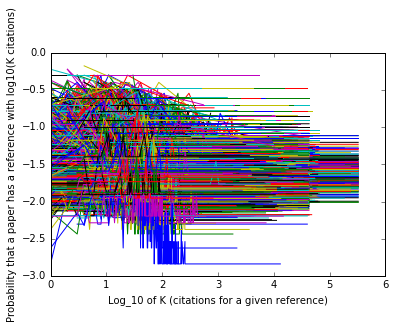

In [33]:
# Probability of log of citation count vs log of citation count. A rather ugly output in the end. Cumulative dists are better
for cite_list in log_cite_counts:
    cite_dict = {}
    for cite_count in cite_list:
        if cite_count not in cite_dict:
            cite_dict[cite_count] = 1
        else:
            cite_dict[cite_count] += 1
            
    prob_cite_count_log = []
    prob_cite_count = []
    actual_cites = []
    for cite_count in sorted(list(cite_dict.keys())):
        cite_count_count = cite_dict[cite_count]
        actual_cites.append(cite_count)
        prob_cite_count_log.append(np.log10(float(cite_count_count)/len(cite_list)))
        prob_cite_count.append(float(cite_count_count)/len(cite_list))
    plt.plot(actual_cites, prob_cite_count_log)
plt.ylabel('Probability that a paper has a reference with log10(K citations)')
plt.xlabel('Log_10 of K (citations for a given reference)')

In [34]:
len(log_cite_counts)

81400

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000


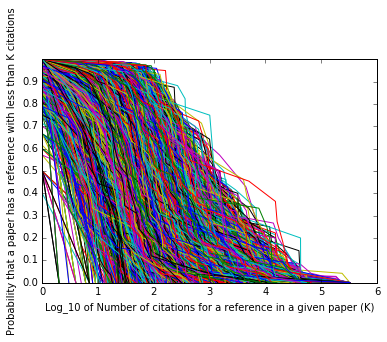

In [35]:
# Inverse cumulative distribution of log of citation counts
# 1 - sum(p(k))

plt.yticks(np.arange(0, 1, 0.1))
plt.ylim(0,1)
#plt.title('Inverse CDF of the citation counts of references for 20,000 PLOS papers')
plt.ylabel('Probability that a paper has a reference with less than K citations')
plt.xlabel('Log_10 of Number of citations for a reference in a given paper (K)')
i = 0
for cite_list in log_cite_counts:
    cite_dict = {}
    for cite_count in cite_list:
        if cite_count not in cite_dict:
            cite_dict[cite_count] = 1
        else:
            cite_dict[cite_count] += 1
            
    prob_cite_count_log = []
    prob_cite_count = []
    actual_cites = [0]
    i+=1
    if i%1000==0:
        print(i)
    cum_prob = 0
    inv_cdf_values = [1]
    for cite_count in sorted(list(cite_dict.keys())):
        cite_count_count = cite_dict[cite_count]
        actual_cites.append(cite_count)
        cum_prob += (float(cite_count_count)/len(cite_list))
        inv_cdf_values.append(1-cum_prob)
        #prob_cite_count_log.append(np.log10(float(cite_count_count)/len(cite_list)))
        #prob_cite_count.append(float(cite_count_count)/len(cite_list))
    

    plt.plot(actual_cites, inv_cdf_values)
plt.show()
    #if i==2:
    #    break

In [15]:
# Generating a raw dictionary of section names - no processing of section titles
sect_titles = {}
for key in ref_dict.keys():
    
    if 'refs' in ref_dict[key]:
        single_paper_cite_counts = []
        for ref_num in sorted(ref_dict[key]['refs'].keys()):
            
            if 'occs' in ref_dict[key]['refs'][ref_num]:
                for occ_num in ref_dict[key]['refs'][ref_num]['occs']:
                    sect_name = ref_dict[key]['refs'][ref_num]['occs'][occ_num][0][0]
                    if sect_name == None:
                        sect_name = ref_dict[key]['refs'][ref_num]['occs'][occ_num][0][1]
                    if 'cite_count' in ref_dict[key]['refs'][ref_num]:
                        cite_count = ref_dict[key]['refs'][ref_num]['cite_count']
                        #single_paper_cite_counts.append(cite_count)
                        if sect_name not in sect_titles:
                            sect_titles[sect_name] = [cite_count]
                        else:
                            sect_titles[sect_name].append(cite_count)
                        

In [181]:
# Optionally, delete all but the most common titles. 500 chosen arbitrarily
#for key in list(sect_titles.keys()):
#    if len(sect_titles[key]) <= 500:
#        del sect_titles[key]

In [186]:
#len(sect_titles['Materials'])

KeyError: 'Materials'

In [16]:
# Attempting to match for the most common section titles. Only four options
import regex as re
intro_re = re.compile(r'(intro)')
method_re = re.compile(r'(method)')
results_re = re.compile(r'(results)')
disc_re = re.compile(r'(disc)')
concl_re = re.compile(r'(conclu)')
backgr_re = re.compile(r'(backgr)')
mater_re = re.compile(r'(mater)')
sect_cites_dict = {}

for key in ref_dict.keys():
    
    if 'refs' in ref_dict[key]:
        single_paper_cite_counts = []
        for ref_num in sorted(ref_dict[key]['refs'].keys()):
            
            if 'occs' in ref_dict[key]['refs'][ref_num]:
                for occ_num in ref_dict[key]['refs'][ref_num]['occs']:
                    sect_name = ref_dict[key]['refs'][ref_num]['occs'][occ_num][0][0]
                    if sect_name == None:
                        sect_name = ref_dict[key]['refs'][ref_num]['occs'][occ_num][0][1]
                    if sect_name != None:

                        if re.search(intro_re, sect_name.lower()) or re.search(backgr_re, sect_name.lower()):
                            key_name = 'intro'
                        elif re.search(method_re, sect_name.lower()) or re.search(mater_re, sect_name.lower()):
                            key_name = 'methods'
                        elif re.search(results_re, sect_name.lower()) or re.search(disc_re, sect_name.lower()):
                            key_name = 'results_disc'
                        elif re.search(concl_re, sect_name.lower()):
                            key_name = 'concl'
                        else:
                            pass

                        if 'cite_count' in ref_dict[key]['refs'][ref_num]:
                            cite_count = ref_dict[key]['refs'][ref_num]['cite_count']
                            #single_paper_cite_counts.append(cite_count)
                            if key_name not in sect_cites_dict:
                                sect_cites_dict[key_name] = [cite_count]
                            else:
                                sect_cites_dict[key_name].append(cite_count)
                        
                    
                
        #all_cites_count_list.append(single_paper_cite_counts)
        

In [17]:
for key in sect_cites_dict:
    print(len(sect_cites_dict[key]))

628795
1629605
12578
2296882


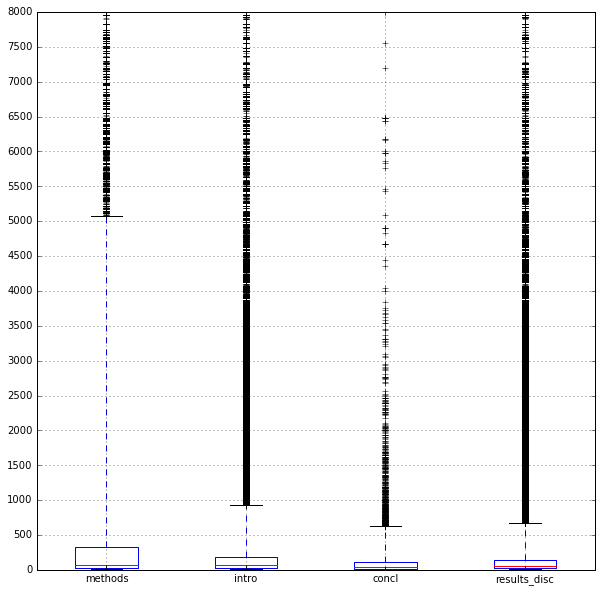

In [18]:
# Plotting distributions of raw counts of citations that occur in each found section

plot_vals = []
xlabels = []
for key in sect_cites_dict:
    plot_vals.append([sect_cites_dict[key]])
    xlabels.append(key)

plt.figure(figsize=(10,10))
#axis.Axis.grid(True)
plt.boxplot(plot_vals, whis = [5,95])

x = [1, 2, 3, 4]
plt.yticks(np.arange(0, 10000, 500))
plt.ylim(0,8000)
plt.xticks(x, xlabels)
plt.grid()


In [21]:
# Sorting into a larger set of section types. Mostly looking to see certain overlaps on combined sections
# For example 'results and discussion' sections are common, whereas 'methods and results' are less common.
# Will still have to account for these different nomenclatures laters.

import regex as re
intro_re = re.compile(r'(intro)')
method_re = re.compile(r'(method)')
results_re = re.compile(r'(results)')
disc_re = re.compile(r'(disc)')
concl_re = re.compile(r'(conclu)')
backgr_re = re.compile(r'(backgr)')
mater_re = re.compile(r'(mater)')
sect_cites_dict = {}  


intro_location_pcts = np.array([])
methods_results_location_pcts = np.array([])
methods_disc_location_pcts = np.array([])
methods_location_pcts = np.array([])
results_disc_location_pcts = np.array([])
results_location_pcts = np.array([])
disc_location_pcts = np.array([])
concl_location_pcts = np.array([])

intro_cite_count = np.array([])
methods_results_cite_count = np.array([])
methods_disc_cite_count= np.array([])
methods_cite_count = np.array([])
results_disc_cite_count = np.array([])
results_cite_count = np.array([])
disc_cite_count = np.array([])
concl_cite_count = np.array([])
i = 0
for key in list(ref_dict.keys()):#[0:17459]:
    i+=1
    if i%5000 == 0:
        
        print(i)
    
    any_cite_location = np.array([])
    any_cite_paper_length = np.array([])


    intro_location = np.array([])
    intro_paper_length = np.array([])

    methods_results_location = np.array([])
    methods_results_paper_length = np.array([])

    methods_disc_location = np.array([])
    methods_disc_paper_length = np.array([])

    methods_location = np.array([])
    methods_paper_length = np.array([])

    results_disc_location = np.array([])
    results_disc_paper_length = np.array([])

    results_location = np.array([])
    results_paper_length = np.array([])

    disc_location = np.array([])
    disc_paper_length = np.array([])

    concl_location = np.array([])
    concl_paper_length = np.array([])
    
    if 'refs' in ref_dict[key]:
        for ref_num in sorted(ref_dict[key]['refs'].keys()):  
            cite_count = -1
            if 'cite_count' in ref_dict[key]['refs'][ref_num]:
                cite_count = ref_dict[key]['refs'][ref_num]['cite_count']
                
                for ordinal in ref_dict[key]['refs'][ref_num]['occs']:
                    fields = ref_dict[key]['refs'][ref_num]['occs'][ordinal]
                    section_names = fields[0]
                    paper_location = fields[1]
                    section_location = fields[2]
                    paragraph_location = fields[3]



                    sect_name = section_names[0]
                    if sect_name == None:
                        sect_name = section_names[1]

                    if sect_name != None:
                        if re.search(intro_re, sect_name.lower()) or re.search(backgr_re, sect_name.lower()):


                            #print section_location
                            #print paper_location

                        #whole paper location:
                            intro_location = np.append(intro_location, section_location[3])
                            intro_paper_length = np.append(intro_paper_length, section_location[4])
                            if cite_count != -1:
                                intro_cite_count = np.append(intro_cite_count, cite_count)

                        elif re.search(method_re,sect_name.lower()) or re.search(mater_re, sect_name.lower()):
                            if re.search(results_re, sect_name.lower()):
                                methods_results_location = np.append(methods_results_location, section_location[3])
                                methods_results_paper_length = np.append(methods_results_paper_length, section_location[4])
                                if cite_count != -1:
                                    methods_results_cite_count = np.append(methods_results_cite_count, cite_count)

                            elif re.search(disc_re, sect_name.lower()):
                                methods_disc_location = np.append(methods_disc_location, section_location[3])
                                methods_disc_paper_length = np.append(methods_disc_paper_length, section_location[4])
                                if cite_count != -1:
                                    methods_disc_cite_count = np.append(methods_disc_cite_count, cite_count)

                            else:
                                methods_location = np.append(methods_location, section_location[3])
                                methods_paper_length = np.append(methods_paper_length, section_location[4])
                                if cite_count != -1:
                                    methods_cite_count = np.append(methods_cite_count, cite_count)

                        elif re.search(results_re, sect_name.lower()):

                            if re.search(disc_re, sect_name.lower()):
                                results_disc_location = np.append(results_disc_location, section_location[3])
                                results_disc_paper_length = np.append(results_disc_paper_length, section_location[4])
                                if cite_count != -1:
                                    results_disc_cite_count = np.append(results_disc_cite_count, cite_count)

                            else:
                                results_location = np.append(results_location, section_location[3])
                                results_paper_length = np.append(results_paper_length, section_location[4])
                                if cite_count != -1:
                                    results_cite_count = np.append(results_cite_count, cite_count)

                        elif re.search(disc_re, sect_name.lower()):
                            disc_location = np.append(disc_location, section_location[3])
                            disc_paper_length = np.append(disc_paper_length, section_location[4])
                            if cite_count != -1:
                                disc_cite_count = np.append(disc_cite_count, cite_count)

                        elif re.search(concl_re, sect_name.lower()):
                            concl_location = np.append(concl_location, section_location[3])
                            concl_paper_length = np.append(concl_paper_length, section_location[4])
                            if cite_count != -1:
                                concl_cite_count = np.append(concl_cite_count, cite_count)
                        else:
                            pass
                    else:
                        pass


            
    intro_location_pcts = np.append(intro_location_pcts, intro_location/intro_paper_length)

    methods_results_location_pcts = np.append(methods_results_location_pcts, methods_results_location/methods_results_paper_length)

    methods_disc_location_pcts = np.append(methods_disc_location_pcts, methods_disc_location/methods_disc_paper_length)

    methods_location_pcts = np.append(methods_location_pcts, methods_location/methods_paper_length)

    results_disc_location_pcts = np.append(results_disc_location_pcts, results_disc_location/results_disc_paper_length)

    results_location_pcts = np.append(results_location_pcts, results_location/results_paper_length)

    disc_location_pcts = np.append(disc_location_pcts, disc_location/disc_paper_length)

    concl_location_pcts = np.append(concl_location_pcts, concl_location/concl_paper_length)

    
    
# Again, this logging ignores 0 citation counts, which are highly common.    
print('Logging cite counts')

log_intro_cites = [np.log10(x) if x!=0 else x for x in intro_cite_count]
log_methods_results_cites = [np.log10(x) if x!=0 else x for x in methods_results_cite_count]
log_methods_disc_cites = [np.log10(x) if x!=0 else x for x in methods_disc_cite_count]
log_methods_cites = [np.log10(x) if x!=0 else x for x in methods_cite_count]
log_results_disc_cites = [np.log10(x) if x!=0 else x for x in results_disc_cite_count]
log_results_cites = [np.log10(x) if x!=0 else x for x in results_cite_count]
log_disc_cites = [np.log10(x) if x!=0 else x for x in disc_cite_count]
log_concl_cites = [np.log10(x) if x!=0 else x for x in concl_cite_count]


5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
Logging cite counts


In [59]:
len(ref_dict)

185320

In [60]:
# Counting up all cited references and all references with cite counts.
tot_cites = 0
tot_refs = 0
for key in list(ref_dict.keys()):#[0:17459]:
    #print(key)
    for ref in ref_dict[key]['refs']:
        tot_refs+=1
        if 'cite_count' in ref_dict[key]['refs'][ref]:
            tot_cites +=1
print(tot_refs)
print(tot_cites)

7782063
2881169


In [38]:
log_intro_cites

[0.84509804001425681,
 0.90308998699194354,
 0.90308998699194354,
 1.7323937598229686,
 1.0791812460476249,
 1.9867717342662448,
 1.6020599913279623,
 1.6020599913279623,
 1.6901960800285136,
 1.6627578316815741,
 1.6627578316815741,
 1.146128035678238,
 1.3979400086720377,
 1.1760912590556813,
 1.8260748027008264,
 1.8260748027008264,
 2.4313637641589874,
 1.4623979978989561,
 0.3010299956639812,
 0.3010299956639812,
 0.47712125471966244,
 0.47712125471966244,
 0.47712125471966244,
 0.47712125471966244,
 1.2041199826559248,
 1.2041199826559248,
 1.2041199826559248,
 1.2041199826559248,
 1.2041199826559248,
 1.2041199826559248,
 1.1139433523068367,
 1.7923916894982539,
 1.7923916894982539,
 1.4913616938342726,
 1.3617278360175928,
 1.5797835966168101,
 1.5797835966168101,
 0.77815125038364363,
 0.90308998699194354,
 0.90308998699194354,
 0.84509804001425681,
 3.8073320392911905,
 1.9590413923210936,
 2.9232440186302764,
 2.2764618041732443,
 2.0170333392987803,
 1.5440680443502757,
 0.

In [116]:
list(ref_dict.keys())[0]

'pone_0101344'

In [115]:
ref_dict[list(ref_dict.keys())[0]]

{'UT': '000339618600013',
 'refs': {1: {'UT': '000249064700047',
   'cite_count': 1157,
   'occs': {1: [('Introduction', None),
     (0, 358, 28805, 59, 5003),
     (0, 358, 2788, 59, 444),
     (0, 358, 706, 59, 115)]}},
  2: {'UT': '000242971100045',
   'cite_count': 2400,
   'occs': {1: [('Introduction', None),
     (0, 368, 28805, 61, 5003),
     (0, 368, 2788, 61, 444),
     (0, 368, 706, 61, 115)]}},
  3: {'UT': '000208863500236',
   'cite_count': 40,
   'occs': {1: [('Introduction', None),
     (0, 386, 28805, 63, 5003),
     (0, 386, 2788, 63, 444),
     (0, 386, 706, 63, 115)]}},
  4: {'UT': '000301652400014',
   'cite_count': 40,
   'occs': {1: [('Introduction', None),
     (0, 513, 28805, 82, 5003),
     (0, 513, 2788, 82, 444),
     (0, 513, 706, 82, 115)],
    2: [('Discussion', None),
     (0, 23007, 28805, 4013, 5003),
     (3, 1980, 7778, 325, 1315),
     (33, 625, 1117, 103, 189)]}},
  5: {'UT': '000310872100001',
   'cite_count': 38,
   'occs': {1: [('Introduction', N

In [112]:
# This plots the density of cite counts. This one attempts to use log and estimates log(0) = log(1). 
# Uninformative because log and density should not go together
from scipy.stats import gaussian_kde
import math
for k in range(len(log_intro_cites)):
    if log_intro_cites[k] == float('NaN') or log_intro_cites[k] == float('Inf') or log_intro_cites[k] == -float('Inf'):
        log_intro_cites[k] = 0
print('step 1: removed nans')
xy = np.vstack([intro_location_pcts[0:20000], log_intro_cites[0:20000]])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x = np.array(intro_location_pcts[0:20000])
y = np.array(log_intro_cites[0:20000])
x, y, z = x[idx], y[idx], z[idx]
print('step 2: plotting')
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, edgecolor='')

plt.title('Log10 of citation counts vs word position')
plt.xlabel('Location of citation word position')
plt.ylabel('Log10 of citation counts')
plt.show()

step 1: removed nans


KeyboardInterrupt: 

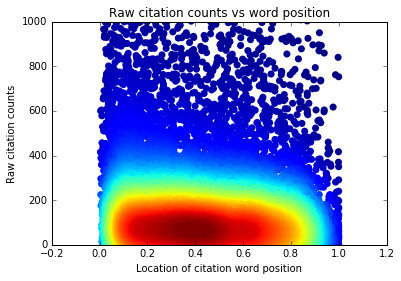

In [85]:
# Raw cite count densities rather than log for the introduction section
from scipy.stats import gaussian_kde
import math
#for k in range(len(intro_cite_count)):
#    if log_intro_cites[k] == float('NaN') or log_intro_cites[k] == float('Inf') or log_intro_cites[k] == -float('Inf'):
#        log_intro_cites[k] = 0

xy = np.vstack([intro_location_pcts[0:20000], intro_cite_count[0:20000]])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x = np.array(intro_location_pcts[0:20000])
y = np.array(intro_cite_count[0:20000])
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, edgecolor='')

plt.title('Raw citation counts vs word position')
plt.xlabel('Location of citation word position')
plt.ylabel('Raw citation counts')
plt.ylim(0,1000)

plt.show()

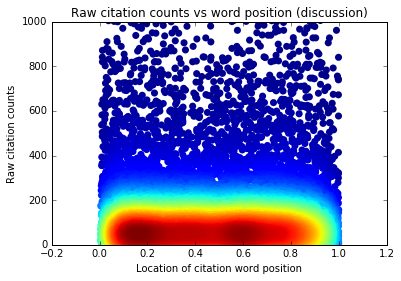

In [75]:
# Raw cite count density for discussion
xy = np.vstack([disc_location_pcts[0:20000], disc_cite_count[0:20000]])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x = np.array(disc_location_pcts[0:20000])
y = np.array(disc_cite_count[0:20000])
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, edgecolor='')

plt.title('Raw citation counts vs word position (discussion)')
plt.xlabel('Location of citation word position')
plt.ylabel('Raw citation counts')
plt.ylim(0,1000)

plt.show()

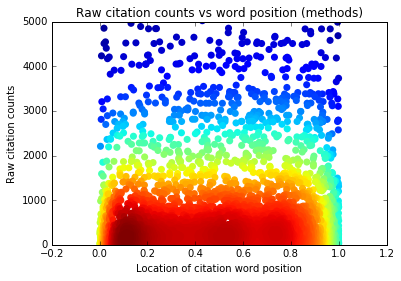

In [80]:
# Same for methods.
xy = np.vstack([methods_location_pcts[0:10000], methods_cite_count[0:10000]])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x = np.array(methods_location_pcts[0:10000])
y = np.array(methods_cite_count[0:10000])
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, edgecolor='')

plt.title('Raw citation counts vs word position (methods)')
plt.xlabel('Location of citation word position')
plt.ylabel('Raw citation counts')
plt.ylim(0,5000)

plt.show()

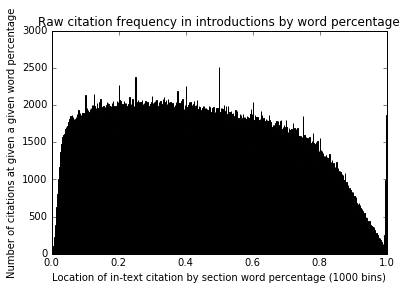

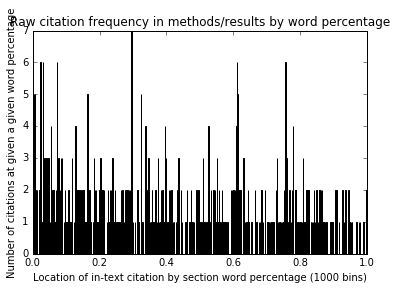

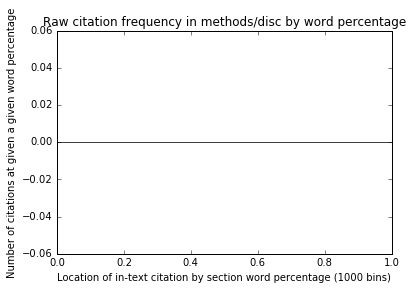

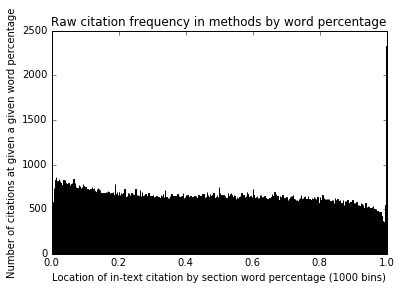

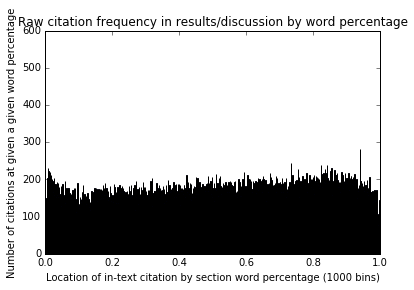

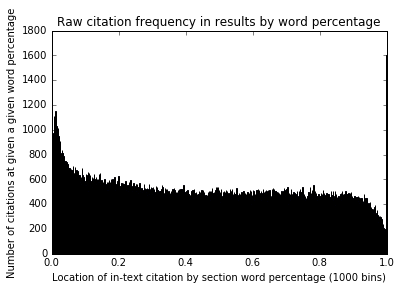

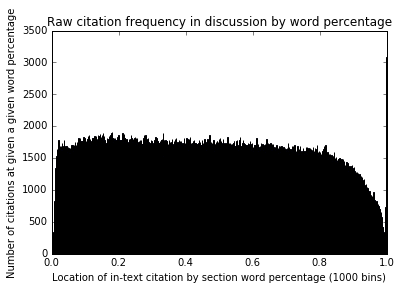

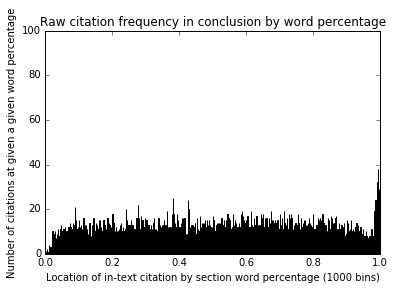

In [88]:
# Plots of the raw citation frequency for each of the main, individual and combined section types. 
# Mostly a sanity check, but for some reasons, either methods sections are underrepresented in the sample I used,
# or they are undersampled in the texts. Note that 'articles' represented in ref_dict are not necessarily
# full journal 'articles.' Things like corrections and reviews still make it in. 
# It's possible to filter out those via 'article type' using the full-text (non-XML) retrievals.

plt.title('Raw citation frequency in introductions by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(intro_location_pcts, bins = 1000)
plt.show()
plt.title('Raw citation frequency in methods/results by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(methods_results_location_pcts, bins = 1000)
plt.show()
plt.title('Raw citation frequency in methods/disc by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(methods_disc_location_pcts, bins = 1000)
plt.show()
plt.title('Raw citation frequency in methods by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(methods_location_pcts, bins = 1000)
plt.show()
plt.title('Raw citation frequency in results/discussion by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(results_disc_location_pcts, bins = 1000)
plt.show()
plt.title('Raw citation frequency in results by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(results_location_pcts, bins = 1000)
plt.show()
plt.title('Raw citation frequency in discussion by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(disc_location_pcts, bins = 1000)
plt.show()
plt.title('Raw citation frequency in conclusion by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(concl_location_pcts, bins = 1000)
plt.show()

In [106]:
# Given a set of location pcts (% of the way through a paper/section), and the corresponding citation count of that
# reference, this sorts them into 100 bins (can change), and then plots the kernel density estimate of all the 
# references in that bin. The tails before the 0 point do not indicate negative counts, just an artifact of the
# KDE curve.

# The max_val portion sorts the curves by bin and then plots the value of the peak. This isn't quite what we need yet.

def location_plotting(location_pcts, cite_count, title):
    bins = np.arange(0,1.01,0.01)

    binplace = np.digitize(location_pcts, bins)


    #binplace = np.digitize(intro_location_pcts, bins)

    dummy_bins = np.arange(0,101)
    max_val_list = []
    ind_list = []

    plt.title('KDE of citation count for ' + title)
    plt.xlabel('Raw citation_count')
    plt.ylabel('KDE probability for citation counts')
    plt.xlim([-100,500])
    plt.ion()
    for i in range(101):
        sub_data = np.array([])
        #bin_ind = []
        if i>1:# and i< 92:
            if len(np.where(binplace == i)[0]) <= 0:
                pass
            else:

                for j in np.where(binplace == i)[0]:

                    sub_data = np.append(sub_data,cite_count[j])

                sns.kdeplot(sub_data, gridsize=10000)
                kde=gaussian_kde(sub_data)
                max_val = max(kde.pdf(dummy_bins))
                max_val_list.append(max_val)
                ind_list.append(i)
                #plt.pause(0.05)
        if i>100:
            break
    plt.show()

    plt.plot(max_val_list)


In [100]:
len(intro_cite_count)


1605013

/Users/Nathan/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


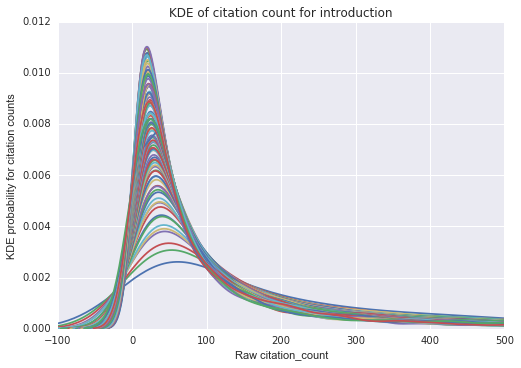

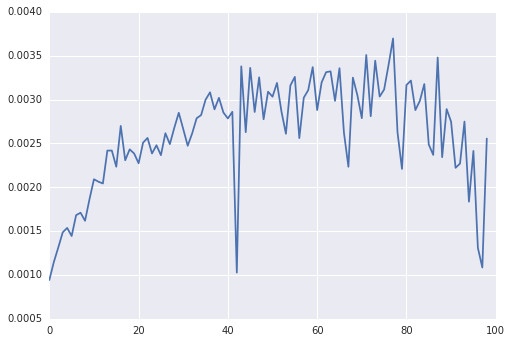

In [107]:
location_plotting(intro_location_pcts, intro_cite_count, 'introduction')


/Users/Nathan/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


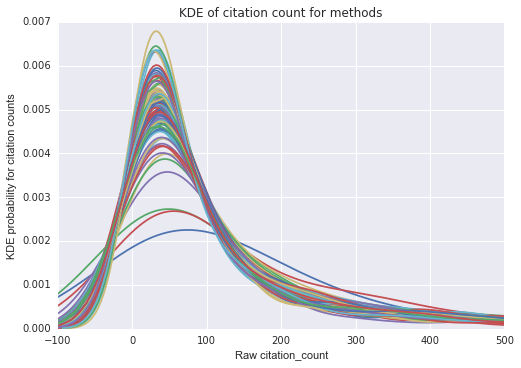

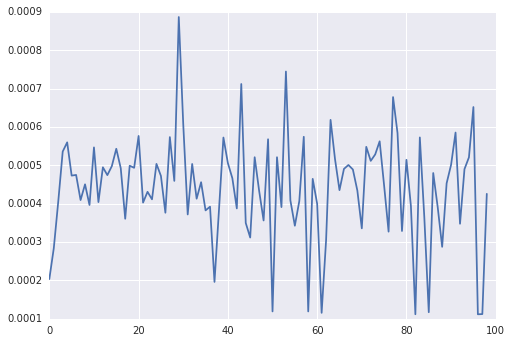

In [91]:
location_plotting(methods_location_pcts, methods_cite_count, 'methods')

/Users/Nathan/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


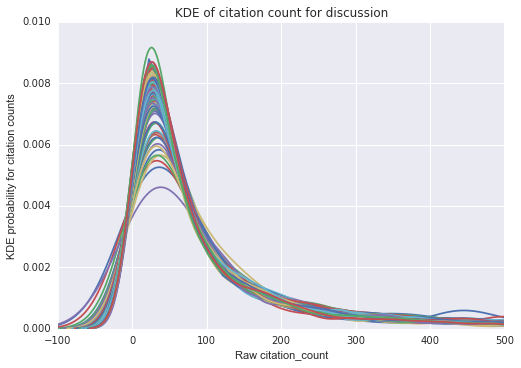

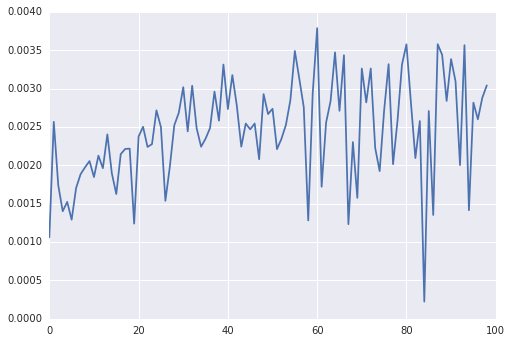

In [90]:
location_plotting(disc_location_pcts, disc_cite_count, 'discussion')

/Users/Nathan/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


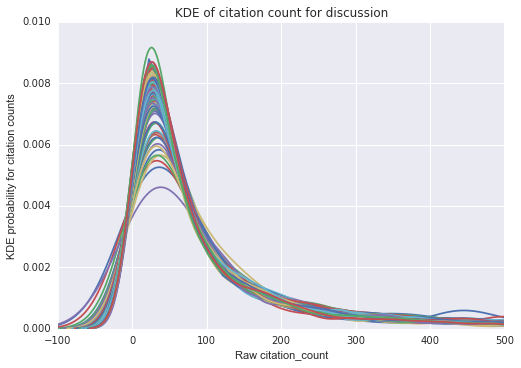

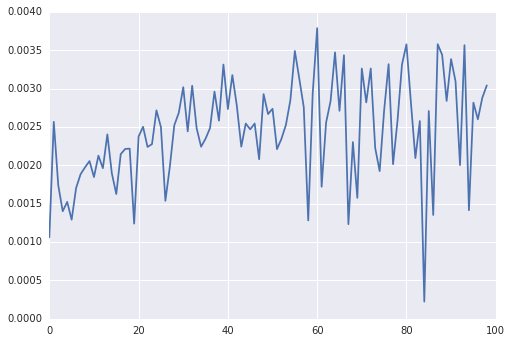

In [92]:
location_plotting(disc_location_pcts, disc_cite_count, 'discussion')


In [103]:
bins = np.arange(0,1.001,0.001)

binplace = np.digitize(intro_location_pcts, bins)

In [99]:
np.where(binplace == 1)[0]
intro_cite_count

array([  91675,  357689,  514741,  534257,  668620, 1167467])

In [40]:
# Framework for normalized cite counts.
normalized_intro_cite_counts = [-1]*len(intro_cite_count)
normalized_intro_locations = [-1]*len(intro_location_pcts)
k=0
for i in range(1001):
    print(i)
    #cite_count_to_extend = [-1]*len(np.where(binplace == i)[0])
    #location_to_extend = [-1]*len(np.where(binplace == i)[0])
    #print(np.where(binplace == i)[0])
    for ind in range(len(np.where(binplace == i)[0])):
        
        j = np.where(binplace == i)[0][ind]
        bin_size = len(np.where(binplace == i)[0])
        
        #print(len(np.where(binplace == i)[0]))
        if len(np.where(binplace == i)[0]) == 0:
            
            pass
        else:
            #print((cite_count_to_extend))
            normalized_intro_cite_counts[k] = intro_cite_count[j]/len(np.where(binplace == i)[0])
            #normalized_intro_locations[k] = intro_location_pcts[j]
            #normalized_intro_cite_counts.append(intro_cite_count[j]/len(np.where(binplace == i)[0]))
            #normalized_intro_locations.append(intro_location_pcts[j])
            #print(intro_cite_count[j])
            #print(len(normalized_intro_cite_counts))
            #print((np.where(binplace == i)[0]))
        k+=1
        if k%1000==0:
            print(k)
    #normalized_intro_cite_counts.extend(cite_count_to_extend)
    #normalized_intro_locations.extend(location_to_extend)
    #print(len(normalized_intro_cite_counts))
    #print(len(normalized_intro_locations))
    #print('----')
    #print(len(np.where(binplace == i)[0]))
    if i ==10:
        break
        
plt.title('Normalized citation counts vs word position')
plt.xlabel('Location of citation word position')
plt.ylabel('Normalized citation counts')
plt.scatter(normalized_intro_locations, normalized_intro_cite_counts)
plt.ylim(0,100)
plt.xlim(0,1)
plt.show()

0
1
1000
2


KeyboardInterrupt: 

In [ ]:
normalized_intro_cite_counts = []
normalized_intro_locations = []
print(len(intro_cite_count))
for i in range(1001):
    print(i)
    cite_count_to_extend = []*len(np.where(binplace == i)[0])
    location_to_extend = []*len(np.where(binplace == i)[0])
    print(np.where(binplace == i)[0])
    for ind in range(len(np.where(binplace == i)[0])):
        j = np.where(binplace == i)[0][ind]
        bin_size = len(np.where(binplace == i)[0])
        
        print(j)
        print(bin_size)
        #print(j)
        if len(np.where(binplace == i)[0]) == 0:
            
            pass
        else:
            print
            cite_count_to_extend[ind] = intro_cite_count[j]/len(np.where(binplace == i)[0][j])
            location_to_extend[ind] = intro_location_pcts[j]
            #normalized_intro_cite_counts.append(intro_cite_count[j]/len(np.where(binplace == i)[0]))
            #normalized_intro_locations.append(intro_location_pcts[j])
            #print(intro_cite_count[j])
            #print(len(normalized_intro_cite_counts))
            #print((np.where(binplace == i)[0]))
    normalized_intro_cite_counts.extend(cite_count_to_extend)
    normalized_intro_locations.extend(location_to_extend)
    #print(len(normalized_intro_cite_counts))
    #print(len(normalized_intro_locations))
    #print('----')
    #print(len(np.where(binplace == i)[0]))
    if i ==4:
        break
        
plt.title('Normalized citation counts vs word position')
plt.xlabel('Location of citation word position')
plt.ylabel('Normalized citation counts')
plt.scatter(normalized_intro_locations, normalized_intro_cite_counts)
plt.ylim(0,100)
plt.xlim(0,1)
plt.show()

0
1


/Users/Nathan/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


2
3
4
5
6


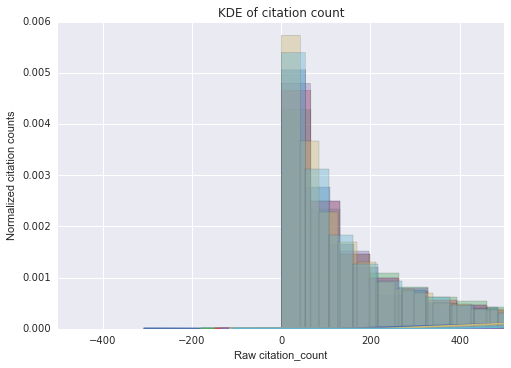

In [30]:
import seaborn as sns
from scipy.stats import gaussian_kde
import math
bins = np.arange(0,1.01,0.01)

binplace = np.digitize(intro_location_pcts, bins)



plt.title('KDE of citation count')
plt.xlabel('Raw citation_count')
plt.ylabel('Normalized citation counts')
for i in range(101):
    print(i)
    sub_data = np.array([])
    #bin_ind = []
    if i:#>10 and i< 90:
        if len(np.where(binplace == i)[0]) <= 0:
            pass
        else:

            for j in np.where(binplace == i)[0]:

                sub_data = np.append(sub_data,intro_cite_count[j])

            sns.distplot(sub_data, bins=1000, hist=True)
    if i ==6:
        break
plt.xlim([-500,500])
plt.show()
        
        #if i >= 10:
        #    break
        

#plt.scatter(normalized_intro_locations, normalized_intro_cite_counts)
#plt.ylim(0,100)
#plt.xlim(0,1)


In [27]:
len(intro_location_pcts)

1605013

/Users/Nathan/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


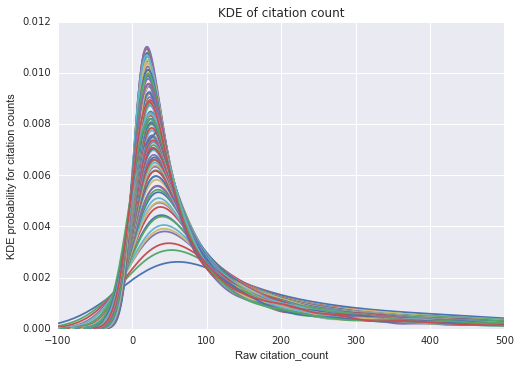

In [104]:
bins = np.arange(0,1.01,0.01)

binplace = np.digitize(intro_location_pcts, bins)

dummy_bins = np.arange(0,101)
max_val_list = []
ind_list = []

plt.title('KDE of citation count')
plt.xlabel('Raw citation_count')
plt.ylabel('KDE probability for citation counts')
plt.xlim([-100,500])
plt.ion()
for i in range(101):
    sub_data = np.array([])
    #bin_ind = []
    if i>1:# and i< 92:
        if len(np.where(binplace == i)[0]) <= 0:
            pass
        else:

            for j in np.where(binplace == i)[0]:

                sub_data = np.append(sub_data,intro_cite_count[j])
            
            sns.kdeplot(sub_data, gridsize=10000)
            kde=gaussian_kde(sub_data)
            max_val = max(kde.pdf(dummy_bins))
            max_val_list.append(max_val)
            ind_list.append(i)
            #plt.pause(0.05)
    if i>100:
        break
plt.show()
            

#plt.show()
        
        #if i >= 10:
        #    break
        

#plt.scatter(normalized_intro_locations, normalized_intro_cite_counts)
#plt.ylim(0,100)
#plt.xlim(0,1)



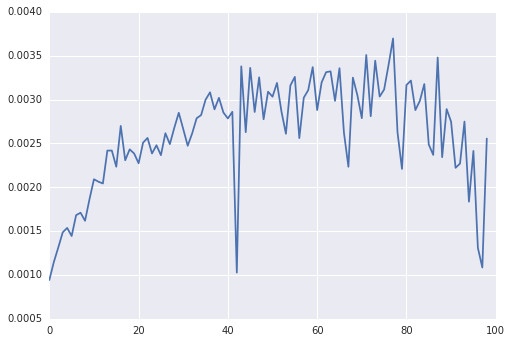

In [105]:
plt.plot(max_val_list)

In [76]:
# Ranking citations (unfinished)
# Where do the first occurences of a citation occur and how highly cited are they?
first_cite_locations = []
i=0
for key in ref_dict:
    #print(key)
    if 'refs' in ref_dict[key]:
        ref_list = sorted(ref_dict[key]['refs'].keys())
        for reference in ref_list:
            first_cite = ref_dict[key]['refs'][reference]['occs'][1]
            first_cite_locations.append(first_cite)

#    i+=1
#    if i%10==0:
#        break
        
    

In [77]:
len(first_cite_locations)

7782063

In [79]:
first_cite_dict = {}
xlabels = []
for cite in first_cite_locations:
    #print(cite[0][0])
    if cite[0][0] in first_cite_dict:
        first_cite_dict[cite[0][0]].append(float(cite[2][3])/cite[2][4])
    else:
        first_cite_dict[cite[0][0]] = []
        xlabels.append(cite[0][0])
#print(first_cite_dict)

plot_vals = []
for sect in xlabels:
    plot_vals.append(first_cite_dict[sect])
print(len(plot_vals))
    
'''plt.figure(figsize=(10,10))
#axis.Axis.grid(True)
plt.boxplot(plot_vals, whis = [5,95])

x = [1, 2, 3, 4, 5, 6, 7]
plt.yticks(np.arange(0, 1, 0.05))
plt.ylim(0,1)
plt.xticks(x, xlabels)
plt.grid()'''

15016


'plt.figure(figsize=(10,10))\n#axis.Axis.grid(True)\nplt.boxplot(plot_vals, whis = [5,95])\n\nx = [1, 2, 3, 4, 5, 6, 7]\nplt.yticks(np.arange(0, 1, 0.05))\nplt.ylim(0,1)\nplt.xticks(x, xlabels)\nplt.grid()'

In [83]:
len(xlabels)

15016

In [55]:
print(len(first_cite_locations))

16


ValueError: x and y must have same first dimension

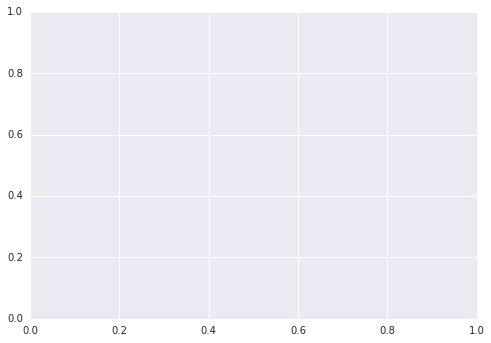

In [44]:
plt.plot(first_cite, first_cite_locations)

In [ ]:
bins = np.arange(0,1.01,0.01)

binplace = np.digitize(intro_location_pcts, bins)



plt.title('KDE for binned text percentages')
plt.xlabel('Log of citation_count')
plt.ylabel('Kernel prob estimate')
for i in range(101):
    sub_data = np.array([])
    #bin_ind = []
    if i>4:
        if len(np.where(binplace == i)[0]) <= 0:
            pass
        else:

            for j in np.where(binplace == i)[0]:

                sub_data = np.append(sub_data,log_intro_cites[j])

            sns.kdeplot(sub_data, gridsize=10000)
            
plt.xlim([-1,5])
plt.show()
        
        #if i >= 10:
        #    break
        

#plt.scatter(normalized_intro_locations, normalized_intro_cite_counts)
#plt.ylim(0,100)
#plt.xlim(0,1)





# Everything below is junk/broken/attempts at regex matching under the old format. Generally ignore.



In [267]:
dummy_bins = np.arange(0,101)
max(kde.pdf(dummy_bins))


0.0023749521148435644

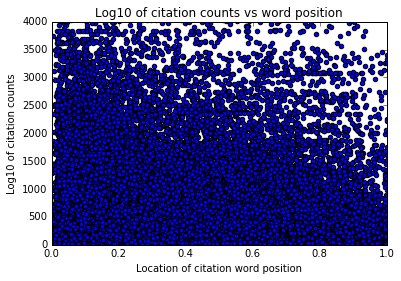

In [328]:
plt.title('Log10 of citation counts vs word position')
plt.xlabel('Location of citation word position')
plt.ylabel('Log10 of citation counts')
plt.scatter(intro_location_pcts, intro_cite_count)
plt.ylim(0,4000)
plt.xlim(0,1)
plt.show()

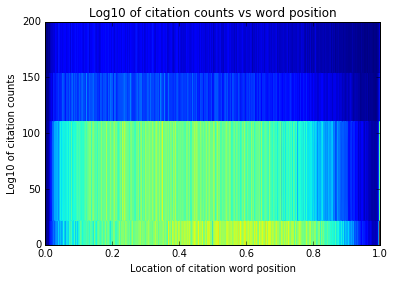

In [363]:
plt.title('Log10 of citation counts vs word position')
plt.xlabel('Location of citation word position')
plt.ylabel('Log10 of citation counts')
plt.subplots_adjust(hspace=0.3)
plt.subplot(111)
plt.hexbin(intro_location_pcts, intro_cite_count, gridsize = 860)
plt.ylim(0,200)
plt.xlim(0,1)
plt.show()

In [296]:
# Sorting by article type
article_dict = {}
list_of_journs = ['pone', 'pbio', 'pcbi', 'pgen', 'pmed', 'pntd', 'ppat', 'pctr'] #['pbio']
for pjournal in list_of_journs:
    path = 'raw_data/%s/'%(pjournal)
    #imax = 10 # maximum articles to read
    #list_fields_read = ['id', 'reference']#'id','title','journal','author','volume','issue','abstract','body', 'reference', 'eissn'] # the properties I want to read from the article

    i=0
    # loop over all files in the folder of the journal
    for fname in glob.glob(path+'*.pckz'):
        #print(fname)
        # load the file of the article
        f = gzip.open(fname)
        key = fname.split('/')[2][:-5]
        #print(key)
        
        x = pickle.load(f)
        f.close()
        
        i+=1
        if i%1000 == 0:
            print(i)
        try:
            article_type = x['article_type']
        except KeyError:
            article_type = 'not available'
        article_dict[key] = article_type
        #if article_type not in article_dict:
        #    article_dict[article_type] = [key]
        #else:
        #    article_dict[article_type].append(key)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
1000
2000

In [297]:
# Correlation to PLOS label

list_of_journs = ['pone', 'pbio', 'pcbi', 'pgen', 'pmed', 'pntd', 'ppat', 'pctr'] #['pbio']
for pjournal in list_of_journs:
    path = 'raw_data/%s/'%(pjournal)
    #imax = 10 # maximum articles to read
    #list_fields_read = ['id', 'reference']#'id','title','journal','author','volume','issue','abstract','body', 'reference', 'eissn'] # the properties I want to read from the article

    i=0
    # loop over all files in the folder of the journal
    for fname in glob.glob(path+'*.pckz'):
        #print(fname)
        # load the file of the article
        f = gzip.open(fname)
        key = fname.split('/')[2][:-5]
        #print(key)
        
        x = pickle.load(f)
        f.close()
        
        i+=1
        if i%1000 == 0:
            print(i)
        try:
            article_type = x['article_type']
        except KeyError:
            article_type = 'not available'
        article_dict[key] = article_type
        #if article_type not in article_dict:
        #    article_dict[article_type] = [key]
        #else:
        #    article_dict[article_type].append(key)

In [300]:
len(research_articles)

['pone_0108533',
 'pone_0125883',
 'pone_0119859',
 'pone_0072688',
 'pone_0110775',
 'pone_0064035',
 'pcbi_1003885',
 'pone_0067080',
 'pone_0076278',
 'pone_0067736',
 'pone_0127360',
 'pone_0074827',
 'pone_0130516',
 'pone_0072775',
 'pone_0122179',
 'pone_0069609',
 'pone_0095098',
 'pone_0075017',
 'pone_0115746',
 'pgen_1004013',
 'pone_0093275',
 'pone_0111857',
 'pgen_1005392',
 'pone_0098627',
 'pone_0085093',
 'pone_0096861',
 'pone_0108297',
 'pone_0086544',
 'pone_0081935',
 'pone_0064796',
 'pcbi_1004177',
 'pone_0145312',
 'pone_0063957',
 'pone_0137855',
 'ppat_1003431',
 'pone_0123893',
 'pone_0068963',
 'pone_0072389',
 'pone_0156467',
 'pgen_1004001',
 'pone_0089258',
 'pone_0128748',
 'pone_0125831',
 'pcbi_1003557',
 'pbio_1002450',
 'ppat_1003502',
 'pone_0108663',
 'pone_0116616',
 'pone_0100115',
 'pone_0084231',
 'pone_0144228',
 'pone_0153415',
 'pone_0152052',
 'pone_0133507',
 'pgen_1004135',
 'pone_0115381',
 'pgen_1005395',
 'pone_0093004',
 'pone_0137622

In [306]:
len(research_articles)

101220

In [178]:

for sect_name in list(sect_cites_dict.keys()):
    if len(sect_cites_dict[sect_name]) <= 100:
        del sect_cites_dict[sect_name]

In [179]:
sect_cites_dict.keys()

dict_keys(['intro', 'concl', 'methods', 'results_disc'])

In [266]:
new_plos_dict = {k: plos_dict[k] for k in c}

In [268]:
with open('../plos_dict_small.json', 'w') as fp:
    json.dump(new_plos_dict, fp)

In [127]:
wos_dois_saved = copy.copy(wos_dois)

In [304]:
with open('../plos_dict_working2.txt', 'wb') as handle:
    pickle.dump(plos_dict, handle, protocol=2)

In [180]:
plos_dict[list(plos_dict.keys())[0]]

{'UT': '000260468900024',
 'references': {0: 'A1994QH20800006',
  1: '000184207300031',
  2: 'A1994NZ24200004',
  3: '000233657600014',
  4: '000077246600048',
  5: '000231610400002',
  6: '000251565300001',
  7: '000181367900027',
  8: '000181281600005',
  9: '000236225300035',
  10: '000237002900018',
  11: '000166434300052',
  12: '000185502300045',
  14: '000235744900001',
  15: '000237954800002',
  16: '000226846100007',
  17: '000186273300015',
  18: '000228986500042',
  19: '000236584400032',
  20: '000244063900026',
  21: '000249124800011',
  22: '000220975100051',
  23: '000224156500016',
  24: '000233593100051',
  25: '000234095500003',
  26: '000075526200004',
  27: '000230195900017',
  28: '000233264300015',
  29: '000175313300001',
  30: '000230449800048',
  31: '000234528000013',
  32: '000226365400006',
  34: '000225676700023',
  35: '000227039200045',
  36: '000185336200004',
  37: '000174227800004',
  38: '000073052900006',
  39: 'A1997WD67900025',
  40: '0002300628000

In [76]:
citation_pos_dict = {}
keys_list = list(plos_dict.keys())
for key in keys_list[:5]:
    citation_pos_dict[key] = {}
    plos_ut = plos_dict[key]['UT']
    citation_pos_dict[key]['UT'] = plos_ut
    doc = papers_con.collection.find_one({"UT": plos_ut})
    
    if 'citations' in doc:
        citation_pos_dict[key]['plos_citation_count']= len(doc['citations'])
    else:
        citation_pos_dict[key]['plos_citation_count'] = None # Maybe this should be 0?
    #citation_pos_dict[key] = {}
    citation_pos_dict[key]['references'] = {}
    
    
    #RUN PARSER
    #Returns cite_list, positions
    
    
    
    
    #for ref_ind in plos_dict[key]['references'].keys():
    for ind in range(len(cite_list)):
        reference = cite_list[ind]
        if reference not in citation_pos_dict[key]['references']:
            citation_pos_dict[key]['references'][reference] = {}
            citation_pos_dict[key]['references'][reference]['positions'] = {}
            next_occ = 1

            if reference in plos_dict[key]['references']:
                citation_pos_dict[key]['references'][reference]['UT'] = plos_dict[key]['references'][reference]
            else:
                citation_pos_dict[key]['references'][reference]['UT'] = None
        else:
            next_occ = max(citation_pos_dict[key]['references'][reference]['positions'].keys())+1

        citation_pos_dict[key]['references'][reference]['positions'][next_occ] = # [Section, positions[ind], ]
            
            
            
            
        if reference in plos_dict[key]['references']:
            
        ref_ut = plos_dict[key]['references'][ref_ind]
        ref_doc = papers_con.collection.find_one({"UT": ref_ut})
        #print(ref_doc)
        
        if 'citations' in ref_doc:
            citation_pos_dict[key][ref_ind] = len(ref_doc['citations'])
            lengths[ref_ut] = len(ref_doc['citations'])


#plos_dict[list(plos_dict.keys())[0]]

SyntaxError: invalid syntax (<ipython-input-76-d715bb2ac46c>, line 38)

SyntaxError: invalid syntax (<ipython-input-76-d715bb2ac46c>, line 38)

In [174]:
citation_lengths

{'000071701800040': 202,
 '000072026300020': 250,
 '000072713900028': 285,
 '000073052900006': 207,
 '000073173100034': 154,
 '000074122900005': 59,
 '000074150100057': 1618,
 '000074467800015': 55,
 '000074521600015': 23,
 '000074950000041': 297,
 '000075143900078': 689,
 '000075246600070': 1084,
 '000075268900029': 154,
 '000075422600004': 273,
 '000075501200030': 32,
 '000075526200004': 34,
 '000075738100041': 3033,
 '000075749300015': 186,
 '000076476000003': 101,
 '000076887700056': 6661,
 '000077246600048': 1111,
 '000079508200052': 2540,
 '000079527800040': 56,
 '000080668600032': 209,
 '000081811100001': 341,
 '000082246500015': 202,
 '000084522800012': 39,
 '000085745600003': 43,
 '000085751100008': 675,
 '000087438300041': 180,
 '000088503800008': 377,
 '000088520100021': 128,
 '000088952500010': 385,
 '000089056200002': 1081,
 '000089379000017': 92,
 '000089441900008': 27,
 '000165560300023': 17,
 '000165993700130': 1092,
 '000166367100009': 252,
 '000166434300052': 2420,
 '

In [163]:
with open('../plos_dict_temp.txt', 'wb') as handle:
    pickle.dump(plos_dict, handle, protocol = 2)

In [9]:

a = 'FUNCTIONALANDANATOMICALORGANIZATIONOFCARDIOVASCULARPRESSORANDDEPRESSORSITESINTHELATERALHYPOTHALAMICAREA1DESCENDINGPROJECTIONS'.lower()
b = "FunctionalandanatomicalorganizationofcardiovascularpressoranddepressorsitesinthelateralhypothalamicareaIDescendingprojections".lower()

In [14]:
#r = re.compile('Theamygdalaandemotion''{e<=5}')

a = 'FUNCTIONALANDANATOMICALORGANIZATIONOFCARDIOVASCULARPRESSORANDDEPRESSORSITESINTHELATERALHYPOTHALAMICAREA1DESCENDINGPROJECTIONS'.lower()
b = "Functionalandanatomicalorganizationofcardiovascularpressoranddepressorsitesinthelateralhypothalamicarea1Descendingprojections".lower()
if re.search("("+a+"){e<=5}", b, re.IGNORECASE):
    print(True)
else:
    print(False)

True


In [13]:
import regex as re

In [349]:
plos_dict.keys()

dict_keys(['pone_0000012', 'pone_0000009', 'pone_0000013', 'pone_0000015', 'pone_0000001', 'pone_0000017'])

In [345]:
len(plos_dict['pone_0000001']['references'])

62

In [274]:
for ut in wos_dois['pone_0000001']['references'].values():
    pap = papers_con.collection.find_one({"UT": ut})
    print(pap['TI'])

FUNCTIONAL AND ANATOMICAL ORGANIZATION OF CARDIOVASCULAR PRESSOR AND DEPRESSOR SITES IN THE LATERAL HYPOTHALAMIC AREA .1. DESCENDING PROJECTIONS
Cold-seeking behavior as a thermoregulatory strategy in systemic inflammation
STIMULATION OF THE PARAVENTRICULAR NUCLEUS WITH GLUTAMATE ACTIVATES INTERSCAPULAR BROWN ADIPOSE-TISSUE THERMOGENESIS IN RATS
Discrete electrolytic lesion of the preoptic area prevents LPS-induced behavioral fever in toads
Bilateral lesion of hypothalamic paraventricular nucleus abolishes fever induced by endotoxin and bradykinin in rats
EFFECT OF PREOPTIC AND ANTERIOR HYPOTHALAMIC LESIONS ON BEHAVIORAL THERMOREGULATION IN COLD
The vanilloid receptor: A molecular gateway to the pain pathway
How do you feel? Interoception: the sense of the physiological condition of the body
Interoception: the sense of the physiological condition of the body
BEHAVIORAL AND AUTONOMIC INDUCTION OF PROSTAGLANDIN-E1 FEVER IN SQUIRREL-MONKEYS
Microinjection of muscimol into caudal periaqued

In [206]:
wos_dois['pone_0000001']


{'UT': '000207443600001',
 'references': {0: 'A1992HB88200006',
  1: '000239502400021',
  2: 'A1990CN04300021',
  3: '000179738900008',
  4: '000077375300036',
  5: 'A1969E446600029',
  6: '000170109100017',
  7: '000177447800016',
  8: '000185403000016',
  9: 'A1975V373400011',
  10: '000239070300013',
  11: '000173992600012',
  12: '000167973400027',
  13: 'A1996UN15100010',
  14: 'A1988P853200004',
  15: '000236130000002',
  16: 'A1994NY98500094',
  17: 'A1989AQ38800008',
  18: '000233296400017',
  19: 'A1991ER58200004',
  21: 'A1994QK18700007',
  22: '000226750600030',
  23: 'A1976CP94600002',
  24: 'A1968A540200025',
  25: 'A1974T430300017',
  26: 'A1993MQ56300004',
  27: '000169454600034',
  28: '000187791500012',
  29: '000185908200026',
  30: 'A1990DF04300007',
  31: '000227503100048',
  32: '000220611600006',
  33: '000166095700003',
  34: 'A1980JM62000026',
  35: '000233807200017',
  36: '000175900700041',
  37: '000165129300003',
  38: '000178431000006',
  39: '0001839115000

In [189]:
plos_dict['pone_0000001']['references']

{1: 'A1988P860700031',
 2: '000166095700003',
 3: '000167973400027',
 4: '000239502400021',
 6: 'A1991ER58200004',
 7: '000078895700111',
 8: 'A1988P853200004',
 9: 'A1994QK18700007',
 11: '000179738900008',
 12: '000175900700041',
 13: '000186119000013',
 15: '000165129300003',
 16: 'A1974T430300017',
 17: 'A1976CZ97400005',
 19: 'A1981MV81300008',
 21: 'A1980JM62000026',
 22: 'A1982MZ13100027',
 23: '000237690400008',
 25: '000169454600034',
 26: '000077375300036',
 27: 'A1994NY98500094',
 28: '000220611600006',
 29: '000173992600012',
 30: '000187791500012',
 31: '000181901700001',
 32: '000185908200026',
 33: 'A1996VH85800034',
 34: '000233807200017',
 35: 'A1976CP94600002',
 36: 'A1989AB76900017',
 37: '000170109100017',
 38: '000183911500017',
 39: '000174314800013',
 40: '000226750600030',
 41: '000227503100048',
 42: '000227124400003',
 43: 'A1977EB59600009',
 44: 'A1970G069400011',
 47: 'A1979HR82600001',
 49: 'A1993KH88400014',
 50: 'A1990CN04300021',
 51: 'A1988N348500004',


In [121]:

test_pap = papers_con.collection.find_one({'UT': wos_dois['pone_0000001']['UT']})

In [122]:
len(test_pap['CR'])

70

In [44]:

papers_con.collection.find_one({"issue.PY": 2007, "issue.SN": '0028-0836'})
#'000248754200012' cited by ['000261559900014', '000249557300023','000249557300022', '000270993600002', '000283408100009']
# T9 is '0115523453'


#papers_con.collection.find_one({'UT': '0105511851'})
#papers_con.collection.find_one({'T9': '0105511851'})

{'AR': 'DOI 10.1038/448742a',
 'AU': {'AF': 'Corinna', 'AU': 'Wu, C', 'LN': 'Wu', 'RO': 'Author'},
 'AV': 'N',
 'BP': '742',
 'CR': [{'/A': 'BENNER, SA',
   '/P': '2425',
   '/V': '97',
   '/W': 'P NATL ACAD SCI USA',
   '/Y': '2000',
   'R9': '0076145932'},
  {'/A': 'BIEMANN, K',
   '/P': '10310',
   '/V': '104',
   '/W': 'P NATL ACAD SCI USA',
   '/Y': '2007',
   'R9': '0115523454',
   'RS': 'DOI 10.1073/pnas.0703732104'},
  {'/A': 'NAVARROGONZALEZ, R',
   '/P': '16089',
   '/V': '103',
   '/W': 'P NATL ACAD SCI USA',
   '/Y': '2006',
   'R9': '0112642066',
   'RS': 'DOI 10.1073/pnas.0604210103'},
  {'/A': 'SKELLEY, AM',
   '/P': '1041',
   '/V': '102',
   '/W': 'P NATL ACAD SCI USA',
   '/Y': '2005',
   'R9': '0105511851',
   'RS': 'DOI 10.1073/pnas.0406798102'}],
 'DT': '5 News Item',
 'EP': '744',
 'ID': 'MARS',
 'LA': 'EN English',
 'NR': '4',
 'PG': '3',
 'T9': '0115523453',
 'TI': 'Space exploration - Secrets of the Martian soil',
 'UT': '000248754200012',
 '_id': ObjectId('54d

In [ ]:
#list_of_journs = ['pone', 'pbio', 'pcbi', 'pgen', 'pmed', 'pntd', 'ppat', 'pctr']
list_of_journs = ['pbio']
lost_count = 0
found_count = 0
citation_dict = {}
all_cites_dict = {}
found_title_count = 0
for pjournal in list_of_journs:
    path = 'raw_data/%s/'%(pjournal)
    imax = 10 # maximum articles to read
    list_fields_read = ['id', 'reference']#'id','title','journal','author','volume','issue','abstract','body', 'reference', 'eissn'] # the properties I want to read from the article

    i=0
    # loop over all files in the folder of the journal
    for fname in glob.glob(path+'*.pckz'):
        print(fname)
        # load the file of the article
        f = gzip.open(fname)
        x = pickle.load(f)
        f.close()
        i+=1
        key = fname.split('/')[2][:-5]
        citation_dict[key] = {} #Initialize 
        citation_dict[key]['id'] = x['id']
        if 'reference' in x:
            for cite_ind in range(len(x['reference'])):
                
                cite = x['reference'][cite_ind]
                citation_dict[key]['papers_cited'] = {}
                

In [ ]:
# Hard part: Going through plos docs to find each of the references, and match them with WoS accession numbers.
# Some citations are not indexed in Web of Science (books, news articles, etc.)
# Develop method of comparing the list of plos citations to wos citations. Title?

#list_of_journs = ['pone', 'pbio', 'pcbi', 'pgen', 'pmed', 'pntd', 'ppat', 'pctr']
list_of_journs = ['pbio']
lost_count = 0
found_count = 0
citation_dict = {}
all_cites_dict = {}
found_title_count = 0
for pjournal in list_of_journs:
#journal = 'ppat' # journal we want to read from (here PlosOne corresponds to 'pone')
    path = 'raw_data/%s/'%(pjournal)
    imax = 10 # maximum articles to read
    list_fields_read = ['id', 'reference']#'id','title','journal','author','volume','issue','abstract','body', 'reference', 'eissn'] # the properties I want to read from the article

    i=0
    # loop over all files in the folder of the journal
    for fname in glob.glob(path+'*.pckz'):
        print(fname)
        # load the file of the article
        f = gzip.open(fname)
        x = pickle.load(f)
        f.close()
        i+=1
        key = fname.split('/')[2][:-5]
        #Lookup accession number for root file from wos_dois
        
        # Building nested dictionary. Each paper needs to have a translation for each reference.
        ##citation_dict[key]['UT'] = wos_dois[key]
        
        # Lookup on WoS database
        ##plos_doc = papers_con.collection.find_one({"UT": wos_dois[key]})
        #if 'citations' in plos_doc:
        #    for cite in plos_doc['citations']:
        #        wos_citations = papers_con.collection.find_one({"UT": cite})
        #print(x['article_type'])
        citation_dict[key] = {} #Initialize 
        citation_dict[key]['id'] = x['id']
        if 'reference' in x:
            for cite_ind in range(len(x['reference'])):
                
                cite = x['reference'][cite_ind]
                citation_dict[key]['papers_cited'] = {}
                
                cite_fields = cite.split(' | ')
                if len(cite_fields) != 4:
                    print('Non 4-length cite field found. Check for | characters')
                    #print(cite_fields)
                #print(cite_fields[3])
                else:
                
                    # Now we have the fields for each citation in a PLOS paper
                    authors = cite_fields[0]
                    year = cite_fields[1]
                    title = cite_fields[2]
                    journ = cite_fields[3]


                    # Lookup journal 

                    # Build regex - JI seems to be the most widely used, but without periods (which the WoS db uses)
                    # Here we make the regex allowing periods. J9 also is good a lot of the time, so that will be searched.
                    # SO is the full text, so we'll want to search that as well. May as well search J1/J2, too
                    
                    if cite_fields[3]: # Here's a pretty big technical problem. Sometimes this field is empty, or it's actually the title. While this suggests that the paper then is just not an indexed journal article, need to think of a way to fix/account for it (character count?) so I can judge the accuracy of the search pipeline. Maybe once I get a full list of all cited journals, I'll check if it shows up with some overall frequency. 
                        fragments = journ.split(' ')
                        journ_text = ''
                        for frag in fragments:
                            if frag != '':
                                
                                if set('.\\+*?[^]$(){}=!<>|:-').intersection(frag):
                                    new_frag = ''
                                    #for char in '.\\+*?[^]$(){}=!<>|:-':
                                        #if char in frag:
                                    for frag_char in frag:
                                        if frag_char in '.\\+*?[^]$(){}=!<>|:-':
                                            new_frag = new_frag + '\\' + frag_char
                                        else:
                                            new_frag = new_frag + frag_char
                                    clean_frag = new_frag
                                else:
                                    clean_frag = frag
                                journ_text = journ_text + clean_frag + '*\.?' + ' '
                        journ_text = journ_text[:-1]
                        #print(fragments)
                        #print(journ_text)
                        
                        # All journals
                        if journ_text not in all_cites_dict:
                            all_cites_dict[journ_text] = ['', 1] # Space if for maybe storing the ISSN.
                        else:
                            all_cites_dict[journ_text][1] += 1
                        
                        journ_query = re.compile(journ_text, re.IGNORECASE)


                        # Search for journal in WoS
                        j_found = 'dummy'
                        journ_variants = ['JI', 'J9', 'SO']
                        for entry in journ_variants:
                            while j_found == 'dummy':
                                try:
                                    j_found = journal_con.collection.find_one({entry: journ_query}, {"_id": 1})
                                    
                                except SocketError:
                                    time.sleep(10)
                            
                            '''try:
                                print(j_found['_id'])
                            except:
                                pass'''
                            if j_found != None and j_found != 'dummy':
                                found_count += 1
                                if found_count%1000 == 0:                                    
                                    print('Found total = ' + str(found_count))
                                break
                        
                        if j_found != None and j_found != 'dummy':
                            j_found_issn = j_found["_id"]
                            ##all_cites_dict[journ_text][0] = j_found_issn
                            #print(j_found_issn)
                            #print(year)
                            year_re = re.sub('[^0-9]+', '', year)
                            cursor = 'dummy' 
                            while cursor is 'dummy': # I don't think this is doing what I want it to do (If connection fails, wait for it to come back and continue)
                                try:
                                    cursor = papers_con.collection.find({"issue.PY": int(year_re), "issue.SN": j_found_issn})
                                except SocketError:
                                    time.sleep(10)
                            #print(cursor.count())
                            #print('Regex journ: ' + journ_text)
                            #print('Year: ' + year)
                            #print('issn: ' + j_found_issn)
                            #print('Title: ' + title)
                        
                            for paper in cursor:
                                
                                
                                #Check for duplicates here maybe?
                                
                                wos_title = re.sub('[^A-Za-z0-9]+', '', paper['TI'])
                                #i['TI'].replace('/[^a-zA-Z0-9]/g', '')
                                plos_title = re.sub('[^A-Za-z0-9]+', '', title)
                                #plos_title = title.replace(/[^a-zA-Z0-9]/g, '')
                                #if (i['TI'] + '*\.?').upper() == title.upper():
                                if wos_title.upper() == plos_title.upper():
                                    print(paper['TI'])
                                    citation_dict[key]['papers_cited'][cite_ind] = paper['UT']
                                    found_title_count += 1
                                    if found_title_count%1000 == 0:                                    
                                        print('Title located, total = ' + str(found_title_count))
                                        print('Found total = ' + str(found_count))
                                    break
                        else:
                            lost_count += 1
                            if lost_count%50 == 0:
                                print('Missing total = ' + str(lost_count))
                            pass


                #print(year)

                # Now to try looking this entry up in the WoS database. 
                #wos_an = wos_dois[x['id']]

            '''try:
                citation_dict[key]['reference'] = x['reference']
            except KeyError:
                citation_dict[key]['reference'] = None'''

            #if i>=imax:
            #    break
            
        # read the fields specified above. try,except if the API did not provide any info for the field.
        
        

In [ ]:
#Making sure matches work
cursor = papers_con.collection.find({"issue.PY": 1995, "issue.SN": '0028-0836'})
print(cursor.count())
for i in cursor:
    if 'SYNAPTIC' in i['TI'].upper():
        print(i['TI'])
    #if i['TI'].upper()=='The synaptic vesicle cycle: A cascade of protein-protein interactions'.upper():
    #    print(True)
#    print(i['TI'])

In [ ]:
journ_query = re.compile('Nucleic*\.? Acids*\.? Res*\.?', re.IGNORECASE)
j_found = journal_con.collection.find_one({'JI': journ_query}, {"_id": 1})
j_found
j_found_issn = j_found["_id"]
cursor = papers_con.collection.find({"issue.PY": 2000, "issue.SN": j_found_issn})
print(cursor.count())
for i in cursor:
    if i['TI'].upper()=='The protein data bank'.upper():
        print(True)
#    print(i['TI'])



In [ ]:
#Example of WoS journal indexing. Regex to match at least one of these
{'J1': ['BOL GEOF TE'],
 'J2': ['B GEOFIS TEOR APPL'],
 'J9': ['BOLL GEOFIS TEOR APPL'],
 'JI': ['Boll. Geofis. Teor. Appl.'],
 'SO': ['BOLLETTINO DI GEOFISICA TEORICA ED APPLICATA'],
 '_id': '0006-6729',
 'fields': ['D GC GEOCHEMISTRY & GEOPHYSICS'],
 'issues': 37}